![alt text](./Cerny_logo_1.jpg)

# Analysis of Cerny ventilation recordings

Analysis of ventilator data obtained from ELBW (birth weight <1000 g) infants transferred during the first 24 hours of life among recordings `AL000001 - AL001100` and  `AT000001 - AT000818`

#### Author: Dr Gusztav Belteki

### 1. Import the required libraries and set options

In [1]:
import IPython
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

import os
import sys
import pickle

from scipy import stats
from pandas import Series, DataFrame
from datetime import datetime, timedelta

%matplotlib inline
matplotlib.style.use('classic')
matplotlib.rcParams['figure.facecolor'] = 'w'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('mode.chained_assignment', None) 

In [2]:
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("NumPy version: {}".format(np.__version__))
print("SciPy version: {}".format(sp.__version__))
print("IPython version: {}".format(IPython.__version__))

Python version: 3.11.7 (main, Dec 15 2023, 12:09:04) [Clang 14.0.6 ]
pandas version: 2.1.4
matplotlib version: 3.8.0
NumPy version: 1.26.3
SciPy version: 1.11.4
IPython version: 8.20.0


### 2. List and set the working directory and the directory to write out data

In [3]:
# Topic of the Notebook which will also be the name of the subfolder containing results
TOPIC = 'ELBW'

# Path to project folder containing clinical data (current weights only) and for export of results
PATH = os.path.join(os.sep, 'Users', 'guszti', 'Library', 'Mobile Documents', 'com~apple~CloudDocs', 
                            'Documents', 'Research', 'Ventilation')

# Name of the external hard drive
DRIVE = 'GUSZTI'

# Data loaded from both directories
DIR_READ_1 = os.path.join(os.sep, 'Volumes', DRIVE, 'data_dump', 'fabian')
DIR_READ_2 = os.path.join(os.sep, 'Volumes', DRIVE, 'data_dump', 'fabian_new')

# Results will be written in this folder
DIR_WRITE =  os.path.join(os.sep, PATH, 'ventilation_fabian_combined', 'Analyses', TOPIC)
os.makedirs(DIR_WRITE, exist_ok=True)

# Images and raw data will be written on an external hard drive
DATA_DUMP = os.path.join(os.sep, 'Volumes', DRIVE, 'data_dump', 'fabian_combined', TOPIC)
os.makedirs(DATA_DUMP, exist_ok=True)

In [4]:
DIR_READ_1, DIR_READ_2, DIR_WRITE, DATA_DUMP

('/Volumes/GUSZTI/data_dump/fabian',
 '/Volumes/GUSZTI/data_dump/fabian_new',
 '/Users/guszti/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/Ventilation/ventilation_fabian_combined/Analyses/ELBW',
 '/Volumes/GUSZTI/data_dump/fabian_combined/ELBW')

### 3. Import clinical data, ventilation modes and blood gases of the final dataset

In [5]:
# These data were exported by the `ELBW_analysis_clinical` Notebook

# Computationally collected data
with open(os.path.join(DATA_DUMP, 'clin_data_comput_ELBW.pickle'), 'rb') as handle:
    clin_data_comput_ELBW = pickle.load(handle)

with open(os.path.join(DATA_DUMP, 'ventilation_modes_ELBW.pickle'), 'rb') as handle:
    vent_modes_ELBW = pickle.load(handle)

with open(os.path.join(DATA_DUMP, 'blood_gases_comput.pickle'), 'rb') as handle:
    blood_gases_comput = pickle.load(handle)

# Manually collected data
# Demographic, clinical and outcome data
with open(os.path.join(DATA_DUMP, 'clin_data_combined.pickle'), 'rb') as handle:
    clinical_data_combined = pickle.load(handle)

# Vital parameters for the final dataset
with open(os.path.join(DATA_DUMP, 'vital_parameters_manual.pickle'), 'rb') as handle:
    vital_parameters = pickle.load(handle)
    
# Blood gases for the final dataset
with open(os.path.join(DATA_DUMP, 'blood_gases_manual.pickle'), 'rb') as handle:
    blood_gases_manual = pickle.load(handle)   

### 4. Import ventilator data from pickle archives

#### A. Import data on ventilated recordings

In [6]:
with open(os.path.join(DIR_READ_1, 'data_pars_measurements_ventilated_1_1100.pickle'), 'rb') as handle:
    data_pars_measurements_1_1100 = pickle.load(handle)
with open(os.path.join(DIR_READ_1, 'data_pars_settings_ventilated_1_1100.pickle'), 'rb') as handle:
    data_pars_settings_1_1100 = pickle.load(handle)
   
with open(os.path.join(DIR_READ_2, 'data_pars_measurements_ventilated_new_1_1305.pickle'), 'rb') as handle:
    data_pars_measurements_new_1_1305 = pickle.load(handle)
with open(os.path.join(DIR_READ_2, 'data_pars_settings_ventilated_new_1_1305.pickle'), 'rb') as handle:
    data_pars_settings_new_1_1305 = pickle.load(handle)

data_pars_measurements_ventilated = {**data_pars_measurements_1_1100, **data_pars_measurements_new_1_1305}
data_pars_settings_ventilated =     {**data_pars_settings_1_1100, **data_pars_settings_new_1_1305}

len(data_pars_measurements_ventilated), len(data_pars_settings_ventilated)

(851, 851)

#### B. Import data on noninvasive recordings

In [7]:
with open(os.path.join(DIR_READ_1, 'data_pars_measurements_noninvasive_1_300.pickle'), 'rb') as handle:
    data_pars_measurements_1_300 = pickle.load(handle)
with open(os.path.join(DIR_READ_1, 'data_pars_settings_noninvasive_1_300.pickle'), 'rb') as handle:
    data_pars_settings_1_300 = pickle.load(handle)

with open(os.path.join(DIR_READ_1, 'data_pars_measurements_noninvasive_301_600.pickle'), 'rb') as handle:
    data_pars_measurements_301_600 = pickle.load(handle)
with open(os.path.join(DIR_READ_1, 'data_pars_settings_noninvasive_301_600.pickle'), 'rb') as handle:
    data_pars_settings_301_600 = pickle.load(handle)

with open(os.path.join(DIR_READ_1, 'data_pars_measurements_noninvasive_601_900.pickle'), 'rb') as handle:
    data_pars_measurements_601_900 = pickle.load(handle)
with open(os.path.join(DIR_READ_1, 'data_pars_settings_noninvasive_601_900.pickle'), 'rb') as handle:
    data_pars_settings_601_900 = pickle.load(handle)

with open(os.path.join(DIR_READ_1, 'data_pars_measurements_noninvasive_901_1100.pickle'), 'rb') as handle:
    data_pars_measurements_901_1100 = pickle.load(handle)
with open(os.path.join(DIR_READ_1, 'data_pars_settings_noninvasive_901_1100.pickle'), 'rb') as handle:
    data_pars_settings_901_1100 = pickle.load(handle)
   
with open(os.path.join(DIR_READ_2, 'data_pars_measurements_noninvasive_new_1_1305.pickle'), 'rb') as handle:
    data_pars_measurements_new_1_1305 = pickle.load(handle)
with open(os.path.join(DIR_READ_2, 'data_pars_settings_noninvasive_new_1_1305.pickle'), 'rb') as handle:
    data_pars_settings_new_1_1305 = pickle.load(handle)

data_pars_measurements_noninvasive = {**data_pars_measurements_1_300, **data_pars_measurements_301_600, 
                                      **data_pars_measurements_601_900, **data_pars_measurements_901_1100,
                                      **data_pars_measurements_new_1_1305}
data_pars_settings_noninvasive =     {**data_pars_settings_1_300, **data_pars_settings_301_600,
                                      **data_pars_settings_601_900, **data_pars_settings_901_1100,
                                      **data_pars_settings_new_1_1305}

len(data_pars_measurements_noninvasive), len(data_pars_settings_noninvasive)

(939, 939)

#### C. Limit ventilator data to the included cases

In [8]:
data_pars_measurements_ventilated = {rec: data_pars_measurements_ventilated[rec] 
                for rec in data_pars_measurements_ventilated if rec in clin_data_comput_ELBW.index}
data_pars_settings_ventilated = {rec: data_pars_settings_ventilated[rec] 
                for rec in data_pars_settings_ventilated if rec in clin_data_comput_ELBW.index}

len(data_pars_measurements_ventilated), len(data_pars_settings_ventilated)

(52, 52)

In [9]:
data_pars_measurements_noninvasive = {rec: data_pars_measurements_noninvasive[rec] 
                for rec in data_pars_measurements_noninvasive if rec in clin_data_comput_ELBW.index}
data_pars_settings_noninvasive = {rec: data_pars_settings_noninvasive[rec] 
                for rec in data_pars_settings_noninvasive if rec in clin_data_comput_ELBW.index}

len(data_pars_measurements_noninvasive), len(data_pars_settings_noninvasive)

(3, 3)

In [10]:
set(data_pars_measurements_ventilated.keys()) & set(data_pars_measurements_noninvasive.keys())

set()

In [11]:
data_pars_measurements = {**data_pars_measurements_ventilated, **data_pars_measurements_noninvasive}
data_pars_settings = {**data_pars_settings_ventilated, **data_pars_settings_noninvasive}
len(data_pars_measurements), len(data_pars_settings)

(55, 55)

### 5. Keep only selected parameters and correct data types when needed

#### A. Keep only parameters and settings relevant for the study

In [12]:
parameters_to_choose_from = {'PIP', 'MAP', 'PEEP',  'MVresp', 'Leak', 'RR', 'FiO2', 'Flow_exp', 'MV_kg', 
                             'VTimand_kg', 'VTemand_kg', 'VTespon_pat_kg', 'VTemand_resp_kg', }

settings_to_choose_from = {'Ventilator_mode', 'PIP_set', 'PEEP_set', 'FiO2_set', 'Flow_insp_set', 'Flow_exp_set', 
                           'Ti_set', 'Te_set', 'RR_set', 'IE_I_set', 'IE_E_set', 'VG_set_kg', 'VG_state', }

for recording, dta in data_pars_measurements.items():
    parameters_to_keep = sorted(set(dta.columns) & parameters_to_choose_from)
    data_pars_measurements[recording] = dta[parameters_to_keep]
    
for recording, dta in data_pars_settings.items():
    settings_to_keep = sorted(set(dta.columns) & settings_to_choose_from)
    data_pars_settings[recording] = dta[settings_to_keep]

#### B. Correct data types

In [13]:
# All measured parameters are floats
for patient in data_pars_measurements:
    data_pars_measurements[patient] = data_pars_measurements[patient].astype('float')

In [14]:
# Settings are floats or categorical

categorical_settings = ['Ventilator_mode',  'VG_state',]

float_settings = ['PIP_set', 'PEEP_set', 'FiO2_set', 'Flow_insp_set', 'Flow_exp_set', 
                  'Ti_set', 'Te_set', 'RR_set', 'IE_I_set', 'IE_E_set', 'VG_set_kg',]

for recording in data_pars_settings:
    for par in float_settings:
        if par in data_pars_settings[recording]:
            data_pars_settings[recording][par] = data_pars_settings[recording][par].astype('float')
    for par in categorical_settings:
        if par in data_pars_settings[recording]:
            data_pars_settings[recording][par] = data_pars_settings[recording][par].astype('category')  

#### C. Combine parameters and settings

In [15]:
data_all = {}

for case in data_pars_measurements.keys():
    vent_pars = data_pars_measurements[case]
    vent_settings = data_pars_settings[case]
    data_all[case] = pd.concat([vent_pars, vent_settings], axis=1)

### 6. Cleanup ventilator data by removing outliers due to artifacts

In [16]:
# Identify and remove abnormal inflations (presumaby ventilation artifacts)

data_points_before_cleanup = {}
for patient in data_all:
    data_points_before_cleanup[patient] = len(data_all[patient])
data_points_before_cleanup;

#### A. Inflations with negative inflating pressure
These are artifacts

In [17]:
Pinfl_negative = {}
for patient in data_all:
    if 'PIP'in data_all[patient].columns and 'PEEP' in data_all[patient].columns:
        Pinfl_negative[patient] = sum(data_all[patient]['PIP'] < data_all[patient]['PEEP'])
Pinfl_negative;

In [18]:
# How many occurrence in the whole dataset
sum(n for n in Pinfl_negative.values())

122

#### B. Inflations with VTemand_kg, VTemand_resp_kg or VTespon_respo_kg >25 mL/kg

Expired VT > 25 mL/kg is likely artifact, representing a flow sensor problem or an open circuit.

In [19]:
VTemand_kg_over25 = {}
for patient in data_all:
    if 'VTemand_kg' in data_all[patient].columns:
        VTemand_kg_over25[patient] = (sum(data_all[patient]['VTemand_kg'] > 25))
VTemand_kg_over25;

In [20]:
# How many occurrence in the whole dataset
sum(n for n in VTemand_kg_over25.values())

7

In [21]:
VTemand_resp_kg_over25 = {}
for patient in data_all:
    if 'VTemand_resp_kg' in data_all[patient].columns:
        VTemand_resp_kg_over25[patient] = (sum(data_all[patient]['VTemand_resp_kg'] > 25))
VTemand_resp_kg_over25;

In [22]:
# How many occurrence in the whole dataset
sum(n for n in VTemand_resp_kg_over25.values())

0

In [23]:
VTespon_pat_kg_over25 = {}
for patient in data_all:
    if 'VTespon_pat_kg' in data_all[patient].columns:
        VTespon_pat_kg_over25[patient] = (sum(data_all[patient]['VTespon_pat_kg'] > 25))
VTespon_pat_kg_over25;

In [24]:
# How many occurrence in the whole dataset
sum(n for n in VTespon_pat_kg_over25.values())

0

#### C. Inflations with MV over 1 L/min/kg

This will not occur during conventional ventilation, unless due to an artifact (eg circuit is open). 

In [25]:
MV_over_1 = {}
for patient in data_all:
    if 'MV_kg' in data_all[patient].columns:
        MV_over_1[patient] = sum(data_all[patient]['MV_kg'] > 1) 
MV_over_1;

In [26]:
# How many occurrence in the whole dataset
sum(n for n in MV_over_1.values())

445

#### D. Inflations with RR  > 130/min

These values are likely abnormal representing autocycling due to condensed water in the circuit

In [27]:
RR_over_130 = {}
for patient in data_all:
    if 'RR' in data_all[patient].columns:
        RR_over_130[patient] = sum(data_all[patient]['RR'] > 130)
RR_over_130;

In [28]:
# How many occurrence in the whole dataset
sum(n for n in RR_over_130.values())

5

#### E. Remove these anomalies from the dataset

Keep rows with missing data of the parameters because other parameters at the same time point may be present and valid

In [29]:
%%time

for patient in data_all:
    #print(patient)
    dta = data_all[patient]
    if 'PIP' in dta and 'PEEP' in dta:
        dta = dta[dta['PIP'].isna() | dta['PEEP'].isna() | (dta['PIP'] >= dta['PEEP'])]
    if 'VTemand_kg' in dta:
        dta = dta[dta['VTemand_kg'].isna() | (dta['VTemand_kg'] <= 25)]
    if 'VTemand_resp_kg' in dta:
        dta = dta[dta['VTemand_resp_kg'].isna() | (dta['VTemand_resp_kg'] <= 25)]
    if 'VTespon_pat_kg' in dta:
        dta = dta[dta['VTespon_pat_kg'].isna() | (dta['VTespon_pat_kg'] <= 25)]
    if 'MV_kg' in dta:
        dta = dta[dta['MV_kg'].isna() | (dta['MV_kg'] <= 1)]
    if 'RR' in dta:
        dta = dta[dta['RR'].isna() | (dta['RR'] <= 130)]
    data_all[patient] = dta

CPU times: user 53.1 ms, sys: 4.15 ms, total: 57.2 ms
Wall time: 56.9 ms


In [30]:
data_points_after_cleanup = {}
for patient in data_all:
    data_points_after_cleanup[patient] = len(data_all[patient])
data_points_after_cleanup;

In [31]:
cleanup_frme = DataFrame([data_points_before_cleanup, data_points_after_cleanup, Pinfl_negative, 
    VTemand_kg_over25, VTemand_resp_kg_over25, VTespon_pat_kg_over25, MV_over_1, RR_over_130]).T
cleanup_frme.columns =   ['data_points_before_cleanup', 'data_points_after_cleanup', 'Pinfl_negative', 
    'VTemand_kg_over25', 'VTemand_resp_kg_over25', 'VTespon_pat_kg_over25', 'MV_over_1', 'RR_over_130',]
cleanup_frme['rows_removed'] = cleanup_frme['data_points_before_cleanup'] - \
                                cleanup_frme['data_points_after_cleanup']
cleanup_frme.sum()

data_points_before_cleanup    155818.0
data_points_after_cleanup     155245.0
Pinfl_negative                   122.0
VTemand_kg_over25                  7.0
VTemand_resp_kg_over25             0.0
VTespon_pat_kg_over25              0.0
MV_over_1                        445.0
RR_over_130                        5.0
rows_removed                     573.0
dtype: float64

In [32]:
cleanup_frme.sum()/ cleanup_frme['data_points_before_cleanup'].sum()

data_points_before_cleanup    1.000000
data_points_after_cleanup     0.996323
Pinfl_negative                0.000783
VTemand_kg_over25             0.000045
VTemand_resp_kg_over25        0.000000
VTespon_pat_kg_over25         0.000000
MV_over_1                     0.002856
RR_over_130                   0.000032
rows_removed                  0.003677
dtype: float64

In [33]:
cleanup_frme.head(2)

,data_points_before_cleanup,data_points_after_cleanup,Pinfl_negative,VTemand_kg_over25,VTemand_resp_kg_over25,VTespon_pat_kg_over25,MV_over_1,RR_over_130,rows_removed
AL000029,1410.0,1406.0,0.0,0.0,0.0,0.0,4.0,NaN,4.0
AL000036,1981.0,1981.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


In [34]:
cleanup_frme.to_csv(os.path.join(DIR_WRITE, f'data_cleanup.csv'))

writer = pd.ExcelWriter(os.path.join(DIR_WRITE, f'data_cleanup.xlsx'))
cleanup_frme.to_excel(writer, 'cleanup_frme')
writer.close()

### 7. Calculate ventilator parameters which are interpreted differently for SIPPV and SIMV 

#### A. Calculate the expired VT of ventilator inflations (VTe_kg) as appropriate for each ventilator mode

In [35]:
for patient, dta in data_all.items():
    # Skip recordings which had only nCPAP
    if 'VTemand_kg' not in dta.columns:
        continue
    
    # For SIMV / SIMVPSV recordings take VTe_kg from VTemand_resp_kg, for SIPPV from VTemand_kg
    if 'SIMV' in dta['Ventilator_mode'].unique() or 'SIMVPSV' in dta['Ventilator_mode'].unique():
        #print(patient)
        dta['VTe_kg'] = np.where(dta['Ventilator_mode'].isin(['SIMV', 'SIMVPSV']), 
            dta['VTemand_resp_kg'], dta['VTemand_kg']) 
    else:
        dta['VTe_kg'] = dta['VTemand_kg']
    
    data_all[patient] = dta

#### B. Calculate the number of mandatory ventilator inflations 

In [36]:
for patient, dta in data_all.items():
    # Skip recordings which had only nCPAP
    if 'VTemand_kg' not in dta.columns:
        continue
    
    # For SIMV / SIMVPSV recordings take RRmand from RR_set, for SIPPV from RR
    if 'SIMV' in dta['Ventilator_mode'].unique() or 'SIMVPSV' in dta['Ventilator_mode'].unique():
        if 'SIPPV' in dta['Ventilator_mode'].unique():
            dta['RRmand'] = np.where(dta['Ventilator_mode'].isin(['SIMV', 'SIMVPSV']), 
                dta['RR_set'], dta['RR']) 
        else:
            dta['RRmand'] = dta['RR_set']    
    else:
        dta['RRmand'] = dta['RR']
    
    data_all[patient] = dta

### 8. Descriptive statistics in the whole dataset

#### A. Statistics on individual cases

In [37]:
percentiles = [0.05, 0.25, 0.5, 0.75, 0.95]
index_names = ['data_points', 'mean', 'SD', 'min', '5pc', '25pc', 'median', '75pc', '95pc', 'max']

stats_all_patients = {} 

for recording in data_all:
    stats_all_patients[recording] = round(data_all[recording].describe(percentiles = percentiles), 2)
    stats_all_patients[recording].index = index_names
    stats_all_patients[recording].dropna(how='all', subset=index_names[1:], axis=1, inplace=True)

In [38]:
# Create table with statistics for all cases and all relevant parameters
stats_all_patients_combined = pd.concat(stats_all_patients, axis = 1).T

stats_all_patients_combined.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1234 entries, ('AL000029', 'FiO2') to ('AT000051', 'PIP_set')
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   data_points  1234 non-null   float64
 1   mean         1234 non-null   float64
 2   SD           1234 non-null   float64
 3   min          1234 non-null   float64
 4   5pc          1234 non-null   float64
 5   25pc         1234 non-null   float64
 6   median       1234 non-null   float64
 7   75pc         1234 non-null   float64
 8   95pc         1234 non-null   float64
 9   max          1234 non-null   float64
dtypes: float64(10)
memory usage: 102.6+ KB


In [39]:
stats_all_patients_combined

data_points   mean     SD    min    5pc   25pc  median  \
AL000029 FiO2           1406.0  33.24  18.62  19.60  19.60  19.70   27.20   
         Leak           1406.0   0.99   6.76   0.00   0.00   0.00    0.00   
         MAP            1406.0   7.75   0.78   0.00   7.30   7.50    7.70   
         MV_kg          1406.0   0.34   0.11   0.07   0.18   0.26    0.35   
         MVresp         1406.0  89.13   9.83   0.00  71.00  84.00   91.00   
...                        ...    ...    ...    ...    ...    ...     ...   
AT000051 MAP            1687.0   6.10   0.40   3.20   5.50   6.20    6.20   
         RR             1687.0   0.00   0.00   0.00   0.00   0.00    0.00   
         FiO2_set       1687.0  21.00   0.00  21.00  21.00  21.00   21.00   
         PEEP_set       1687.0   5.92   0.33   4.00   5.50   6.00    6.00   
         PIP_set        1687.0  12.00   0.00  12.00  12.00  12.00   12.00   

                    75pc    95pc     max  
AL000029 FiO2      39.80   71.80  100.00  
         Leak       0.00    0.00   68.00  
         MAP        7.90    8.30   11.20  
         MV_kg      0.42    0.52    0.69  
         MVresp    97.00  100.00  100.00  
...                  ...     ...     ...  
AT000051 MAP        6.20    6.30    7.60  
         RR         0.00    0.00    0.00  
         FiO2_set  21.00   21.00   21.00  
         PEEP_set   6.00    6.00    6.00  
         PIP_set   12.00   12.00   12.00  

[1234 rows x 10 columns]

#### B. Statistics on selected individual parameters and setting

In [40]:
# Selected individual parameters and settings

pars_selected = ['FiO2_set', 'MAP', 'PIP', 'PEEP', 'VTe_kg', 'RRmand', 'MV_kg', 'Ti_set', 'Te_set', 'Leak']

stats_all_parameters = {}

for par in pars_selected:
    stats_all_parameters[par] = stats_all_patients_combined.swaplevel(0,1).loc[par].sort_values('mean', ascending = False)

In [41]:
# Unstack table to create table with different configuration
stats_all_parameters_combined = pd.concat(stats_all_parameters, axis=1)

stats_all_parameters_combined.head()

FiO2_set                                                      \
         data_points   mean     SD   min   5pc  25pc median  75pc   95pc   
AL000267      4471.0  60.18  12.36  35.0  50.0  60.0   60.0  60.0  100.0   
AT000549      2805.0  57.70  12.16  40.0  40.0  50.0   55.0  70.0   75.0   
AT000613      5055.0  57.62   7.40  21.0  55.0  55.0   55.0  60.0   80.0   
AL000687      2656.0  51.89   5.14  30.0  50.0  50.0   50.0  50.0   60.0   
AT000714      3388.0  51.23   4.36  21.0  40.0  50.0   50.0  55.0   55.0   

                        MAP                                                   \
            max data_points   mean    SD  min   5pc  25pc median  75pc  95pc   
AL000267  100.0      4471.0  12.12  1.43  0.0  11.0  11.9   12.3  12.7  13.1   
AT000549   75.0      2805.0  14.66  1.22  0.0  12.9  14.2   14.8  15.4  15.8   
AT000613   80.0      5055.0  11.33  1.12  0.0  10.2  10.9   11.4  11.6  12.8   
AL000687   60.0      2656.0   8.70  0.81  0.0   7.4   8.3    8.7   9.1   9.8   
AT000714   55.0      3388.0   9.76  0.80  0.0   8.7   9.5    9.9  10.1  10.6   

                       PIP                                                     \
           max data_points   mean    SD   min    5pc  25pc median  75pc  95pc   
AL000267  14.9      4471.0  28.33  3.71   0.8  23.50  27.5   28.6  30.2  31.8   
AT000549  17.1      2805.0  25.94  2.16  16.8  22.02  24.4   26.5  27.4  28.6   
AT000613  15.8      5055.0  26.89  3.05   3.0  21.07  24.4   27.8  29.3  30.3   
AL000687  11.5      2656.0  15.01  2.67   3.0   9.80  13.8   15.2  16.5  19.0   
AT000714  11.5      3388.0  21.81  0.70  18.0  20.10  21.8   22.0  22.2  22.4   

                      PEEP                                                   \
           max data_points  mean    SD  min  5pc 25pc median 75pc 95pc  max   
AL000267  34.2      4471.0  5.90  0.58  0.4  5.5  5.9    6.1  6.1  6.2  9.0   
AT000549  34.1      2805.0  7.06  0.26  6.1  6.4  7.0    7.1  7.1  7.4  8.8   
AT000613  38.9      5055.0  6.15  0.14  1.5  6.0  6.1    6.2  6.2  6.3  7.2   
AL000687  27.1      2656.0  6.07  0.21  1.0  5.9  6.0    6.1  6.1  6.3  7.4   
AT000714  23.1      3388.0  6.48  0.44  5.1  5.8  5.9    6.7  6.8  6.9  7.9   

              VTe_kg                                                          \
         data_points  mean    SD   min   5pc  25pc median  75pc  95pc    max   
AL000267      4471.0  6.91  0.55  2.88  6.08  6.72   6.88  7.04  7.84  11.52   
AT000549      2805.0  5.25  0.33  3.75  4.75  5.00   5.37  5.50  5.62   7.62   
AT000613      5055.0  4.57  0.97  0.00  2.80  4.40   4.80  5.00  5.40  16.20   
AL000687      2656.0  5.30  0.71  0.00  4.47  4.94   5.18  5.41  6.59  10.71   
AT000714      3388.0  2.77  2.00  0.00  0.92  1.85   2.15  3.08  7.38  14.92   

              RRmand                                                           \
         data_points   mean    SD   min   5pc  25pc median  75pc  95pc    max   
AL000267      4471.0  43.93  5.59   0.0  41.0  43.0   44.0  45.0  49.0  113.0   
AT000549      2805.0  70.49  8.58   0.0  53.0  68.0   74.0  76.0  78.0   82.0   
AT000613      5055.0  40.97  6.07   0.0  38.0  40.0   40.0  42.0  49.0   71.0   
AL000687      2656.0  53.96  6.24   0.0  46.0  50.0   55.0  58.0  63.0   80.0   
AT000714      3388.0  42.16  2.48  40.0  40.0  40.0   40.0  45.0  45.0   45.0   

               MV_kg                                                         \
         data_points  mean    SD   min   5pc  25pc median  75pc  95pc   max   
AL000267      4471.0  0.31  0.03  0.12  0.27  0.30   0.30  0.32  0.37  0.74   
AT000549      2805.0  0.39  0.06  0.00  0.28  0.37   0.40  0.42  0.48  0.78   
AT000613      5055.0  0.21  0.09  0.00  0.09  0.17   0.19  0.23  0.39  0.77   
AL000687      2656.0  0.29  0.03  0.13  0.25  0.28   0.29  0.31  0.35  0.46   
AT000714      3388.0  0.15  0.13  0.00  0.03  0.08   0.10  0.15  0.41  1.00   

              Ti_set                                                         \
         data_points  mean    SD  

#### C. Group statistics on selected parameters

In [42]:
pars_for_mean = ['PIP', 'MAP', 'PEEP', 'MV_kg', 'VTe_kg', 'RRmand',]

group_stats_all_mean = \
    round(stats_all_parameters_combined.swaplevel(axis=1)['mean'].describe()[pars_for_mean].T, 2)
group_stats_all_mean

,count,mean,std,min,25%,50%,75%,max
PIP,52.0,19.91,5.91,8.47,15.92,20.05,23.78,31.63
MAP,55.0,9.53,2.30,5.96,8.10,9.52,10.80,15.36
PEEP,52.0,5.90,0.71,3.43,5.76,6.06,6.18,7.08
MV_kg,52.0,0.30,0.10,0.09,0.24,0.30,0.34,0.63
VTe_kg,52.0,5.42,1.52,1.30,4.60,5.04,6.15,9.52
RRmand,53.0,48.83,14.22,0.00,39.28,48.69,59.16,79.44


In [43]:
pars_for_median = ['FiO2_set', 'Leak', 'Ti_set', 'Te_set']

group_stats_all_median = \
    round(stats_all_parameters_combined.swaplevel(axis=1)['median'].describe()[pars_for_median].T, 2)
group_stats_all_median

,count,mean,std,min,25%,50%,75%,max
FiO2_set,55.0,30.09,10.27,21.00,21.00,25.00,34.50,60.00
Leak,52.0,9.65,19.08,0.00,0.00,0.00,15.00,90.00
Ti_set,52.0,0.36,0.03,0.30,0.34,0.35,0.38,0.40
Te_set,52.0,1.11,0.34,0.64,0.86,1.06,1.21,2.66


#### C. Export statistics to a multisheet Excel file and pickle archive

In [44]:
# Save statistics into Excel file
writer = pd.ExcelWriter(os.path.join(DIR_WRITE, 'stats_all_patients_ELBW.xlsx'))
for patient in stats_all_patients:
    stats_all_patients[patient].to_excel(writer, patient)
writer.close()

In [45]:
# Save statistics into Excel file
writer = pd.ExcelWriter(os.path.join(DIR_WRITE, 'stats_all_parameters_ELBW.xlsx'))
for parameter in stats_all_parameters:
    stats_all_parameters[parameter].to_excel(writer, parameter)
writer.close()

In [46]:
# Save statistics into Excel file
writer = pd.ExcelWriter(os.path.join(DIR_WRITE, 'stats_all_combined_ELBW.xlsx'))
stats_all_patients_combined.to_excel(writer, 'patients')
stats_all_parameters_combined.to_excel(writer, 'parameters')
writer.close()

In [47]:
# Save group statistics into Excel file
writer = pd.ExcelWriter(os.path.join(DIR_WRITE, 'group_stats_all_ELBW.xlsx'))
group_stats_all_mean.to_excel(writer, 'parametric')
group_stats_all_median.to_excel(writer, 'non_parametric')
writer.close()

### 9. Combine data from all recordings, and export overall statistics about it as an Excel file

As this includes all data with various ventilator modes, some parameters should be interpreted with caution

In [48]:
data_all_combined = pd.concat(data_all)

In [49]:
data_all_combined.describe()

,FiO2,Leak,MAP,MV_kg,MVresp,PEEP,PIP,VTemand_kg,VTemand_resp_kg,VTespon_pat_kg,VTimand_kg,FiO2_set,Flow_exp_set,Flow_insp_set,IE_E_set,IE_I_set,PEEP_set,PIP_set,RR_set,Te_set,Ti_set,VTe_kg,RRmand,RR,VG_set_kg,Flow_exp
count,155245.000000,148113.000000,155245.000000,148113.000000,43431.000000,148113.000000,148113.000000,148113.000000,43431.000000,43431.000000,148113.000000,155245.000000,148113.000000,148113.000000,148113.000000,148113.000000,155245.000000,155245.000000,148113.000000,148113.000000,148113.000000,148107.000000,150242.000000,144429.000000,132088.000000,7132.000000
mean,30.108606,11.791646,9.859900,0.305931,80.563722,6.029095,20.290216,5.249640,4.934845,1.817395,6.910467,30.935541,5.558594,9.017220,3.016841,1.003451,6.134500,27.489903,42.641976,1.103372,0.362693,5.376093,50.463898,51.009534,5.594419,8.582850
std,14.759735,19.998748,2.759878,0.139362,23.751772,0.846226,7.070884,1.978856,2.283605,1.930561,8.797932,12.315257,1.917857,1.802979,1.147389,0.018253,0.565428,7.706509,7.805957,0.348776,0.028313,1.986891,16.678018,22.554838,1.524056,0.954539
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,4.000000,5.000000,1.000000,1.000000,4.000000,10.000000,20.000000,0.640000,0.300000,0.000000,0.000000,0.000000,2.250000,5.601000
25%,20.600000,0.000000,8.100000,0.223750,71.000000,5.900000,15.800000,4.137931,3.789474,0.000000,5.000000,21.000000,4.000000,8.000000,2.400000,1.000000,6.000000,22.000000,40.000000,0.850000,0.350000,4.375000,40.000000,43.000000,4.705882,8.299000
50%,25.200000,0.000000,9.900000,0.287879,90.000000,6.100000,20.300000,5.000000,4.848485,1.616162,5.866667,25.000000,4.000000,9.500000,2.800000,1.000000,6.000000,30.000000,44.000000,1.014000,0.350000,5.050505,50.000000,54.000000,5.066667,8.713000
75%,35.200000,16.000000,11.500000,0.364444,100.000000,6.500000,26.100000,6.105263,5.833333,3.045685,7.200000,35.000000,8.000000,10.000000,3.400000,1.000000,6.000000,35.000000,50.000000,1.160000,0.400000,6.166667,62.000000,65.000000,6.000000,9.407000
max,100.000000,90.000000,18.800000,1.000000,100.000000,17.400000,43.000000,23.444444,15.656566,11.111111,1000.000000,100.000000,10.000000,15.000000,7.800000,1.100000,7.000000,40.000000,60.000000,2.660000,0.400000,23.444444,129.000000,129.000000,24.637681,10.530000


In [50]:
writer = pd.ExcelWriter(os.path.join(DIR_WRITE, f'descriptive_stats_combined_ELBW.xlsx'))
cleanup_frme.to_excel(writer, 'stats_all_combined')
writer.close()

### 10. Analyse ventilator modes used

#### A. Ventilator modes

Some modes do not occur in this dataset

In [51]:
vent_modes_ELBW.sum()

IPPV              0.0
PSV               0.0
SIMV          71288.0
SIMVPSV       15654.0
SIPPV        210430.0
O2therapy         0.0
DUOPAP            0.0
NCPAP         14264.0
CPAP              0.0
HFO               0.0
VG_on        265230.0
total        311636.0
dtype: float64

In [53]:
# Limit vent mode table to modes which did occur
vent_modes_ELBW = vent_modes_ELBW[['SIMV', 'SIMVPSV', 'SIPPV', 'NCPAP', 'total', 'VG_on',]]
vent_modes_ELBW.head()

,SIMV,SIMVPSV,SIPPV,NCPAP,total,VG_on
AL000029,2820.0,0.0,0.0,0.0,2820,0.0
AL000036,0.0,0.0,3962.0,0.0,3962,3962.0
AL000089,2596.0,0.0,886.0,0.0,3482,3464.0
AL000104,3362.0,0.0,5160.0,0.0,8522,8516.0
AL000110,0.0,0.0,6902.0,0.0,6902,5402.0


#### B. Assign recordings where >95% is one mode to that mode

In [54]:
predominantly_sippv = set(vent_modes_ELBW[vent_modes_ELBW['SIPPV'] > vent_modes_ELBW['total'] * 0.95].index)
len(predominantly_sippv)

29

In [55]:
vent_modes_ELBW.loc[sorted(predominantly_sippv)]

,SIMV,SIMVPSV,SIPPV,NCPAP,total,VG_on
AL000036,0.0,0.0,3962.0,0.0,3962,3962.0
AL000110,0.0,0.0,6902.0,0.0,6902,5402.0
AL000115,0.0,0.0,8160.0,0.0,8160,7660.0
AL000116,0.0,0.0,4502.0,0.0,4502,4438.0
AL000226,0.0,0.0,9600.0,0.0,9600,9582.0
AL000267,0.0,0.0,8942.0,0.0,8942,8942.0
AL000294,0.0,0.0,2400.0,0.0,2400,0.0
AL000344,0.0,0.0,7560.0,0.0,7560,7560.0
AL000469,6.0,0.0,9774.0,0.0,9780,9780.0
AL000554,0.0,0.0,5312.0,0.0,5312,5312.0


In [56]:
predominantly_simv = set(vent_modes_ELBW[vent_modes_ELBW['SIMV'] > vent_modes_ELBW['total'] * 0.95].index)
len(predominantly_simv)

13

In [57]:
vent_modes_ELBW.loc[sorted(predominantly_simv)]

,SIMV,SIMVPSV,SIPPV,NCPAP,total,VG_on
AL000029,2820.0,0.0,0.0,0.0,2820,0.0
AL000138,2492.0,0.0,0.0,0.0,2492,0.0
AL000176,3780.0,0.0,0.0,0.0,3780,3780.0
AL000330,5520.0,0.0,0.0,0.0,5520,5520.0
AL000374,5642.0,0.0,0.0,0.0,5642,5642.0
AL000693,5342.0,0.0,0.0,0.0,5342,5342.0
AL000842,3030.0,0.0,0.0,0.0,3030,2966.0
AL000904,4080.0,0.0,0.0,0.0,4080,4080.0
AL000960,2352.0,0.0,0.0,0.0,2352,2352.0
AT000076,3420.0,0.0,0.0,0.0,3420,3420.0


In [58]:
predominantly_simv_ps = set(vent_modes_ELBW[vent_modes_ELBW['SIMVPSV'] > vent_modes_ELBW['total'] * 0.95].index)
len(predominantly_simv_ps)

2

In [59]:
vent_modes_ELBW.loc[sorted(predominantly_simv_ps)]

,SIMV,SIMVPSV,SIPPV,NCPAP,total,VG_on
AT000714,0.0,6782.0,0.0,0.0,6782,0.0
AT000761,0.0,5258.0,0.0,0.0,5258,246.0


In [60]:
# They are all fully nCPAP as these babies were not intubated
predominantly_ncpap = set(vent_modes_ELBW[vent_modes_ELBW['NCPAP'] > vent_modes_ELBW['total'] * 0.95].index)
len(predominantly_ncpap)

3

In [61]:
vent_modes_ELBW.loc[sorted(predominantly_ncpap)]

,SIMV,SIMVPSV,SIPPV,NCPAP,total,VG_on
AL000253,0.0,0.0,0.0,4260.0,4260,0.0
AL000762,0.0,0.0,0.0,6630.0,6630,0.0
AT000051,0.0,0.0,0.0,3374.0,3374,0.0


In [62]:
no_predominant_mode = set(vent_modes_ELBW.index) - (predominantly_simv | predominantly_simv_ps |
                          predominantly_sippv |  predominantly_ncpap)
vent_modes_ELBW.loc[sorted(no_predominant_mode)]

,SIMV,SIMVPSV,SIPPV,NCPAP,total,VG_on
AL000089,2596.0,0.0,886.0,0.0,3482,3464.0
AL000104,3362.0,0.0,5160.0,0.0,8522,8516.0
AL000152,3540.0,3602.0,0.0,0.0,7142,0.0
AL000246,668.0,0.0,6344.0,0.0,7012,7012.0
AL000465,3126.0,0.0,894.0,0.0,4020,4020.0
AL000687,1038.0,0.0,4274.0,0.0,5312,5312.0
AT000009,650.0,0.0,4540.0,0.0,5190,5190.0
AT000578,3638.0,0.0,1974.0,0.0,5612,5612.0


In [63]:
both_simv_and_sippv = no_predominant_mode.copy()
# Exclude recordings which have SIMV and SIMVPSV
both_simv_and_sippv.discard('AL000152')
vent_modes_ELBW.loc[sorted(both_simv_and_sippv)]

,SIMV,SIMVPSV,SIPPV,NCPAP,total,VG_on
AL000089,2596.0,0.0,886.0,0.0,3482,3464.0
AL000104,3362.0,0.0,5160.0,0.0,8522,8516.0
AL000246,668.0,0.0,6344.0,0.0,7012,7012.0
AL000465,3126.0,0.0,894.0,0.0,4020,4020.0
AL000687,1038.0,0.0,4274.0,0.0,5312,5312.0
AT000009,650.0,0.0,4540.0,0.0,5190,5190.0
AT000578,3638.0,0.0,1974.0,0.0,5612,5612.0


In [64]:
# Exclude recordings which have SIMV and SIPPV
both_simv_and_simvpsv = no_predominant_mode - both_simv_and_sippv
vent_modes_ELBW.loc[sorted(both_simv_and_simvpsv)]

,SIMV,SIMVPSV,SIPPV,NCPAP,total,VG_on
AL000152,3540.0,3602.0,0.0,0.0,7142,0.0


#### Assign those ones with >95% VG or noVG to those modes

In [65]:
predominantly_vg = set(vent_modes_ELBW[vent_modes_ELBW['VG_on'] > vent_modes_ELBW['total'] * 0.95].index)
vent_modes_ELBW.loc[sorted(predominantly_vg)]

,SIMV,SIMVPSV,SIPPV,NCPAP,total,VG_on
AL000036,0.0,0.0,3962.0,0.0,3962,3962.0
AL000089,2596.0,0.0,886.0,0.0,3482,3464.0
AL000104,3362.0,0.0,5160.0,0.0,8522,8516.0
AL000116,0.0,0.0,4502.0,0.0,4502,4438.0
AL000176,3780.0,0.0,0.0,0.0,3780,3780.0
AL000226,0.0,0.0,9600.0,0.0,9600,9582.0
AL000246,668.0,0.0,6344.0,0.0,7012,7012.0
AL000267,0.0,0.0,8942.0,0.0,8942,8942.0
AL000330,5520.0,0.0,0.0,0.0,5520,5520.0
AL000344,0.0,0.0,7560.0,0.0,7560,7560.0


In [66]:
len(predominantly_vg)

41

In [68]:
predominantly_novg = set(vent_modes_ELBW[vent_modes_ELBW['VG_on'] < vent_modes_ELBW['total'] * 0.05].index) & \
                     set(vent_modes_ELBW[vent_modes_ELBW['NCPAP'] < vent_modes_ELBW['total'] * 0.05].index)
vent_modes_ELBW.loc[sorted(predominantly_novg)]

,SIMV,SIMVPSV,SIPPV,NCPAP,total,VG_on
AL000029,2820.0,0.0,0.0,0.0,2820,0.0
AL000138,2492.0,0.0,0.0,0.0,2492,0.0
AL000152,3540.0,3602.0,0.0,0.0,7142,0.0
AL000294,0.0,0.0,2400.0,0.0,2400,0.0
AT000714,0.0,6782.0,0.0,0.0,6782,0.0
AT000761,0.0,5258.0,0.0,0.0,5258,246.0


In [69]:
len(predominantly_novg)

6

In [70]:
both_vg_novg = set(vent_modes_ELBW[ (vent_modes_ELBW['VG_on'] >= vent_modes_ELBW['total'] * 0.05) & 
                  (vent_modes_ELBW['VG_on'] <= vent_modes_ELBW['total'] * 0.95)].index)
vent_modes_ELBW.loc[sorted(both_vg_novg)]

,SIMV,SIMVPSV,SIPPV,NCPAP,total,VG_on
AL000110,0.0,0.0,6902.0,0.0,6902,5402.0
AL000115,0.0,0.0,8160.0,0.0,8160,7660.0
AL001019,0.0,0.0,2332.0,0.0,2332,2184.0
AT000437,0.0,0.0,4920.0,0.0,4920,4610.0
AT000613,0.0,0.0,10114.0,0.0,10114,8000.0


#### C. Save tables with ventilator modes into Excel file

In [71]:
writer = pd.ExcelWriter(os.path.join(DIR_WRITE, 'vent_modes_ELBW_categories.xlsx'))
vent_modes_ELBW.to_excel(writer, 'all')
vent_modes_ELBW.loc[sorted(predominantly_simv)].to_excel(writer, 'predominantly_simv')
vent_modes_ELBW.loc[sorted(predominantly_simv_ps)].to_excel(writer, 'predominantly_simv_ps')
vent_modes_ELBW.loc[sorted(predominantly_sippv)].to_excel(writer, 'predominantly_sippv')
vent_modes_ELBW.loc[sorted(predominantly_ncpap)].to_excel(writer, 'predominantly_ncpap')
vent_modes_ELBW.loc[sorted(no_predominant_mode)].to_excel(writer, 'no_predominant_mode')
vent_modes_ELBW.loc[sorted(both_simv_and_sippv)].to_excel(writer, 'both_simv_and_sippv')
vent_modes_ELBW.loc[sorted(both_simv_and_simvpsv)].to_excel(writer, 'both_simv_and_simvpsv')

vent_modes_ELBW.loc[sorted(predominantly_vg)].to_excel(writer, 'predominantly_vg')
vent_modes_ELBW.loc[sorted(predominantly_novg)].to_excel(writer, 'predominantly_novg')
vent_modes_ELBW.loc[sorted(both_vg_novg)].to_excel(writer, 'both_vg_novg')
writer.close()

### 11. Limit data to the given ventilator modes

In [72]:
# Recordings with one mode only

# SIPPV only
data_sippv = {}
for case in predominantly_sippv:
    data_sippv[case] = data_all[case][data_all[case]['Ventilator_mode'] == 'SIPPV']

# SIMV only
data_simv = {}
for case in predominantly_simv:
    data_simv[case] = data_all[case][data_all[case]['Ventilator_mode'] == 'SIMV']

# NCPAP
# None of these recordings has any other mode as the baby was not intubated
data_ncpap = {}
for case in predominantly_ncpap:
    data_ncpap[case] = data_all[case][data_all[case]['Ventilator_mode']== 'NCPAP']

In [73]:
# Recordings with more than one mode

# SIPPV and SIMV in the same recording
data_both_sippv_simv = {}
for case in both_simv_and_sippv:
    data_both_sippv_simv[case] = data_all[case][data_all[case]['Ventilator_mode'].isin(['SIMV', 'SIPPV'])]
    
# SIMV and SIMVPSV in the same recording
data_both_simv_simvpsv = {}
for case in both_simv_and_simvpsv:
    data_both_simv_simvpsv[case] = data_all[case][data_all[case]['Ventilator_mode'].isin(['SIMV', 'SIMVPSV'])]

In [74]:
# VG only
data_vg = {}
for case in predominantly_vg:
    data_vg[case] = data_all[case][data_all[case]['VG_state'] == 'on']

# no VG only
# None of these recordings had any VG periods therefore (see above table), therefore there is nothing to remove
data_novg = {}
for case in predominantly_novg:
    data_novg[case] = data_all[case]

# both VG and no VG
data_both_vg_novg = {}
for case in both_vg_novg:
    data_both_vg_novg[case] = data_all[case]

### 12. Further process ventilator data specific to different ventilator modes

#### A. Recordings with SIPPV

In [75]:
data_sippv_all = pd.concat(data_sippv)

In [76]:
# For SIPPV MVresp should be n/a as it is always 100%
data_sippv_all = data_sippv_all.drop('MVresp', axis=1)

# During SIPPV VTemand_resp_kg and VTespon_resp_kg are not valid
data_sippv_all = data_sippv_all.drop(['VTemand_resp_kg', 'VTespon_pat_kg'], axis=1)

# Drop Flow_exp as no data
data_sippv_all = data_sippv_all.drop('Flow_exp', axis=1)

# RR_diff is the difference between the set and actual ventilator rate
data_sippv_all['RR_diff'] = data_sippv_all['RRmand'] - data_sippv_all['RR_set'] 

data_sippv_all.describe()

,FiO2,Leak,MAP,MV_kg,PEEP,PIP,RR,VTemand_kg,VTimand_kg,FiO2_set,Flow_exp_set,Flow_insp_set,IE_E_set,IE_I_set,PEEP_set,PIP_set,RR_set,Te_set,Ti_set,VG_set_kg,VTe_kg,RRmand,RR_diff
count,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,88832.000000,92704.000000,92704.000000,92704.000000
mean,32.434451,7.758932,10.919174,0.329544,6.236166,21.201567,57.020258,5.609881,6.409310,32.127988,5.751057,8.888349,2.545164,1.003549,6.288467,30.154049,45.840633,0.963372,0.371076,5.655235,5.609881,57.020258,11.179625
std,14.201122,12.173382,2.597486,0.133523,0.764085,7.047429,12.821020,1.875536,9.329776,13.143579,1.989506,1.659426,0.589725,0.018501,0.588416,6.114643,6.239135,0.187381,0.022951,1.534086,1.875536,12.821020,13.625380
min,17.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,4.000000,5.000000,1.000000,1.000000,5.000000,13.000000,20.000000,0.640000,0.300000,2.250000,0.000000,0.000000,-60.000000
25%,21.600000,0.000000,9.500000,0.253750,6.000000,16.700000,49.000000,4.533333,5.052632,21.000000,4.000000,8.000000,2.300000,1.000000,6.000000,25.000000,40.000000,0.850000,0.350000,4.800000,4.533333,49.000000,1.000000
50%,29.400000,0.000000,10.900000,0.304444,6.100000,21.700000,58.000000,5.172414,6.000000,30.000000,4.000000,10.000000,2.400000,1.000000,6.000000,30.000000,45.000000,0.933000,0.360000,5.111111,5.172414,58.000000,9.000000
75%,35.500000,14.000000,12.500000,0.370408,6.800000,27.200000,66.000000,6.444444,7.058824,35.000000,8.000000,10.000000,2.800000,1.000000,7.000000,35.000000,50.000000,1.100000,0.400000,6.400000,6.444444,66.000000,19.000000
max,100.000000,90.000000,18.800000,1.000000,17.400000,39.600000,129.000000,23.444444,1000.000000,100.000000,10.000000,12.000000,6.500000,1.100000,7.000000,40.000000,60.000000,2.600000,0.400000,17.142857,23.444444,129.000000,79.000000


#### B. Recordings with SIMV 

In [77]:
data_simv_all = pd.concat(data_simv)

In [78]:
# Drop Flow_exp as no data
data_simv_all = data_simv_all.drop('Flow_exp', axis=1)

data_simv_all.describe()

,FiO2,Leak,MAP,MV_kg,MVresp,PEEP,PIP,VTemand_kg,VTemand_resp_kg,VTespon_pat_kg,VTimand_kg,FiO2_set,Flow_exp_set,Flow_insp_set,IE_E_set,IE_I_set,PEEP_set,PIP_set,RR_set,Te_set,Ti_set,VTe_kg,RRmand,RR,VG_set_kg
count,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,16342.000000,23620.000000
mean,25.845480,12.569989,8.250278,0.272487,76.629486,5.687013,18.451912,4.866457,5.466441,2.149586,7.131948,28.109527,5.545925,9.765435,4.197400,1.006923,5.799479,28.622263,35.429364,1.471419,0.339332,5.466441,35.429364,33.931159,5.350296
std,15.072002,21.705376,1.718566,0.122011,23.343440,0.618612,6.749591,1.846431,1.841182,1.788544,4.354437,9.517372,1.947809,2.403435,1.764152,0.025385,0.346094,7.413255,8.314085,0.526358,0.021433,1.841182,8.314085,33.247525,1.405886
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,21.000000,4.000000,6.000000,1.000000,1.000000,5.000000,18.000000,20.000000,0.741000,0.300000,0.000000,20.000000,0.000000,4.040404
25%,20.100000,0.000000,6.900000,0.200000,67.000000,5.400000,13.300000,3.750000,4.545455,0.000000,4.949495,21.000000,4.000000,8.000000,3.200000,1.000000,5.500000,22.000000,30.000000,1.140000,0.330000,4.545455,30.000000,0.000000,4.670051
50%,21.000000,0.000000,8.300000,0.255000,83.000000,5.900000,18.400000,4.343434,5.000000,2.121212,5.466667,23.000000,4.000000,9.500000,4.000000,1.000000,6.000000,26.000000,35.000000,1.384000,0.340000,5.000000,35.000000,47.000000,5.050505
75%,31.600000,17.000000,9.500000,0.303158,95.000000,6.100000,23.700000,5.333333,5.866667,3.131313,8.266667,30.000000,8.000000,10.000000,4.700000,1.000000,6.000000,35.000000,40.000000,1.640000,0.350000,5.866667,40.000000,66.000000,5.066667
max,100.000000,89.000000,15.100000,0.988000,100.000000,7.700000,43.000000,15.858586,15.656566,11.111111,49.789474,100.000000,8.000000,15.000000,7.800000,1.100000,7.000000,40.000000,55.000000,2.660000,0.380000,15.656566,55.000000,119.000000,10.000000


#### C. Recordings with both SIPPV and SIMV

In [79]:
data_both_sippv_simv_all = pd.concat(data_both_sippv_simv)

In [80]:
# Drop Flow_exp as no data
data_both_sippv_simv_all = data_both_sippv_simv_all.drop('Flow_exp', axis=1)

data_both_sippv_simv_all.describe()

,FiO2,Leak,MAP,MV_kg,MVresp,PEEP,PIP,RR,VTemand_kg,VTemand_resp_kg,VTespon_pat_kg,VTimand_kg,FiO2_set,Flow_exp_set,Flow_insp_set,IE_E_set,IE_I_set,PEEP_set,PIP_set,RR_set,Te_set,Ti_set,VG_set_kg,VTe_kg,RRmand
count,19512.000000,19512.000000,19512.000000,19512.000000,7532.000000,19512.000000,19512.000000,18658.000000,19512.000000,7532.000000,7532.000000,19512.000000,19512.000000,19512.000000,19512.000000,19512.000000,19512.0,19512.000000,19512.000000,19512.000000,19512.000000,19512.000000,19500.000000,19506.000000,19511.000000
mean,25.836818,7.974631,8.672012,0.328692,74.605019,5.452019,18.330966,59.390771,5.458989,6.215789,2.603602,6.393533,30.720736,4.983805,8.369670,3.430648,1.0,5.860547,22.549149,38.274754,1.246884,0.367727,5.605823,5.571937,50.042899
std,16.127432,12.268916,2.894129,0.129901,28.304319,1.163956,8.284058,24.366139,1.550116,2.120698,2.355585,7.690121,10.966019,1.722643,1.291158,0.879195,0.0,0.533898,6.423742,6.419469,0.283822,0.030569,1.576655,1.710008,20.682572
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,4.000000,6.000000,2.000000,1.0,5.000000,15.000000,30.000000,0.800000,0.320000,4.040404,0.000000,0.000000
25%,20.300000,0.000000,6.500000,0.212405,57.000000,4.900000,11.300000,42.000000,4.747475,4.747475,0.000000,5.176471,21.000000,4.000000,7.000000,2.800000,1.0,6.000000,17.000000,30.000000,1.024000,0.340000,5.000000,4.705882,35.000000
50%,24.600000,0.000000,8.300000,0.314493,91.000000,6.000000,17.100000,51.000000,5.151515,5.757576,3.000000,5.797101,25.000000,4.000000,8.000000,3.100000,1.0,6.000000,22.000000,40.000000,1.100000,0.360000,5.000000,5.151515,44.000000
75%,29.900000,13.000000,10.500000,0.451515,100.000000,6.200000,27.500000,77.000000,5.797101,7.246377,4.637681,6.500000,40.000000,4.000000,10.000000,4.000000,1.0,6.000000,30.000000,44.000000,1.600000,0.400000,6.060606,5.942029,56.000000
max,98.500000,90.000000,18.500000,0.908750,100.000000,8.900000,33.200000,116.000000,14.750000,13.750000,9.595960,867.101449,70.000000,8.000000,10.000000,5.300000,1.0,7.000000,40.000000,50.000000,1.680000,0.400000,24.637681,14.750000,116.000000


#### D. Recordings with both SIMV and SIMVPSV

In [81]:
data_both_simv_simvpsv_all = pd.concat(data_both_simv_simvpsv)

data_both_simv_simvpsv_all.describe()

,FiO2,Leak,MAP,MV_kg,MVresp,PEEP,PIP,RR,VTemand_kg,VTemand_resp_kg,VTespon_pat_kg,VTimand_kg,FiO2_set,Flow_exp_set,Flow_insp_set,IE_E_set,IE_I_set,PEEP_set,PIP_set,RR_set,Te_set,Ti_set,VTe_kg,RRmand
count,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.0,3571.0,3571.000000,3571.0,3571.0,3571.000000,3571.000000,3571.000000,3.571000e+03,3571.000000,3571.000000
mean,24.837048,22.871185,8.640885,0.124862,95.174181,6.056399,19.696836,41.455335,2.940017,3.042173,0.447270,3.892523,24.583310,4.0,8.0,4.145842,1.0,6.0,19.644357,38.958275,1.244586,3.000000e-01,3.042173,38.958275
std,5.738047,7.736826,0.588948,0.028310,10.079900,0.219230,0.814352,5.174480,0.842178,0.893714,0.860334,0.915645,1.222108,0.0,0.0,0.284327,0.0,0.0,0.764832,2.030908,0.086923,1.987578e-14,0.893714,2.030908
min,18.800000,0.000000,0.000000,0.036000,0.000000,0.000000,1.200000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,4.0,8.0,4.000000,1.0,6.0,18.000000,35.000000,1.200000,3.000000e-01,0.000000,35.000000
25%,24.600000,18.000000,8.500000,0.106000,93.000000,6.000000,19.600000,39.000000,2.400000,2.600000,0.000000,3.400000,25.000000,4.0,8.0,4.000000,1.0,6.0,20.000000,40.000000,1.200000,3.000000e-01,2.600000,40.000000
50%,25.000000,23.000000,8.700000,0.122000,100.000000,6.100000,19.900000,39.000000,2.800000,3.000000,0.000000,3.800000,25.000000,4.0,8.0,4.000000,1.0,6.0,20.000000,40.000000,1.200000,3.000000e-01,3.000000,40.000000
75%,25.500000,28.000000,8.800000,0.140000,100.000000,6.100000,20.200000,42.000000,3.200000,3.400000,0.800000,4.200000,25.000000,4.0,8.0,4.000000,1.0,6.0,20.000000,40.000000,1.200000,3.000000e-01,3.400000,40.000000
max,96.900000,57.000000,9.400000,0.292000,100.000000,6.700000,21.300000,65.000000,8.200000,9.800000,4.800000,10.000000,25.000000,4.0,8.0,4.700000,1.0,6.0,20.000000,40.000000,1.414000,3.000000e-01,9.800000,40.000000


#### E. Recordings with nasal CPAP

In [82]:
data_ncpap_all = pd.concat(data_ncpap)

In [83]:
columns_to_keep = ['FiO2', 'Flow_exp', 'MAP', 'FiO2_set', 'PEEP_set', 'PIP_set', 'Ventilator_mode',]
data_ncpap_all = data_ncpap_all[columns_to_keep]

data_ncpap_all.describe()

,FiO2,Flow_exp,MAP,FiO2_set,PEEP_set,PIP_set
count,7132.000000,7132.000000,7132.000000,7132.000000,7132.000000,7132.000000
mean,22.886441,8.582850,6.069560,23.400589,5.981071,11.402692
std,6.829726,0.954539,0.503968,5.234703,0.166187,0.915400
min,19.400000,5.601000,0.900000,21.000000,4.000000,10.000000
25%,19.900000,8.299000,6.100000,21.000000,6.000000,10.000000
50%,20.200000,8.713000,6.100000,21.000000,6.000000,12.000000
75%,24.700000,9.407000,6.200000,25.000000,6.000000,12.000000
max,98.500000,10.530000,7.600000,72.000000,6.000000,12.000000


#### F. Recordings with VG

For SIMV and SIMVPSV recordings `VTemand_resp_kg` is to be used as here there can be spontaneous breaths between ventilator inflation whose tidal volume is not targeted, for SIPPV use `VTemand_kg`

In [84]:
for patient, dta in data_vg.items():
    
    # The difference between the actual and the target expired VT
    dta['VT_diff_kg'] = dta['VTe_kg'] - dta['VG_set_kg']
    # Calculate absolute value of the difference
    dta['VT_diff_kg_abs'] = np.abs(dta['VT_diff_kg'])

    dta['P_diff'] = dta['PIP_set'] - dta['PIP']
    # Calculate absolute value of the difference
    dta['P_diff_abs'] = np.abs(dta['P_diff'])
    
    data_vg[patient] = dta
    data_vg_all = pd.concat(data_vg)

# Drop Flow_exp as no data
data_vg_all = data_vg_all.drop('Flow_exp', axis=1)

data_vg_all.describe()

,FiO2,Leak,MAP,MV_kg,MVresp,PEEP,PIP,RR,VTemand_kg,VTemand_resp_kg,VTespon_pat_kg,VTimand_kg,FiO2_set,Flow_exp_set,Flow_insp_set,IE_E_set,IE_I_set,PEEP_set,PIP_set,RR_set,Te_set,Ti_set,VG_set_kg,VTe_kg,RRmand,VT_diff_kg,VT_diff_kg_abs,P_diff,P_diff_abs
count,118058.000000,118058.000000,118058.000000,118058.000000,31167.000000,118058.000000,118058.000000,108648.000000,118058.000000,31167.000000,31167.000000,118058.000000,118058.000000,118058.000000,118058.000000,118058.000000,118058.000000,118058.000000,118058.000000,118058.000000,118058.000000,118058.000000,118058.000000,118052.000000,118057.000000,118052.000000,118052.000000,118058.000000,118058.000000
mean,28.780582,8.447907,10.138657,0.329262,75.344563,6.049854,20.211298,56.046600,5.529661,5.582400,2.253604,6.623141,29.878534,5.680005,8.870788,3.029755,1.004305,6.170327,29.108769,42.436980,1.119041,0.364157,5.646338,5.660973,52.790203,0.014663,0.588416,8.897471,9.533209
std,14.659208,13.874519,2.889014,0.133781,25.292750,0.867605,7.609861,20.369702,1.834670,1.877318,1.948884,8.626324,11.665433,1.995096,1.905798,1.238919,0.020296,0.594969,6.421096,8.364977,0.380129,0.026490,1.578552,1.817327,16.380965,1.315428,1.176575,8.131934,7.376393
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,4.000000,5.000000,1.000000,1.000000,5.000000,15.000000,20.000000,0.640000,0.300000,3.392857,0.000000,0.000000,-18.695652,0.000000,-15.200000,0.000000
25%,20.500000,0.000000,8.100000,0.250505,60.000000,5.900000,14.700000,46.000000,4.333333,4.568528,0.000000,5.052632,21.000000,4.000000,8.000000,2.300000,1.000000,6.000000,25.000000,40.000000,0.880000,0.350000,4.800000,4.625000,42.000000,-0.222222,0.111111,3.000000,3.600000
50%,25.000000,0.000000,10.100000,0.303333,84.000000,6.100000,20.500000,59.000000,5.102041,5.050505,2.166667,5.918367,25.000000,4.000000,9.000000,2.800000,1.000000,6.000000,30.000000,44.000000,1.014000,0.360000,5.111111,5.166667,53.000000,0.000000,0.222222,7.100000,7.500000
75%,34.400000,14.000000,12.000000,0.383750,96.000000,6.700000,27.000000,68.000000,6.346154,6.060606,3.600000,7.200000,35.000000,8.000000,10.000000,3.400000,1.000000,7.000000,35.000000,48.000000,1.160000,0.400000,6.060606,6.400000,64.000000,0.200000,0.666667,14.200000,14.200000
max,100.000000,90.000000,18.800000,1.000000,100.000000,17.400000,43.000000,129.000000,23.444444,15.656566,11.111111,1000.000000,100.000000,10.000000,15.000000,7.800000,1.100000,7.000000,40.000000,60.000000,2.660000,0.400000,24.637681,23.444444,129.000000,17.888889,18.695652,37.000000,37.000000


#### G. Recordings without VG

In [85]:
for patient, dta in data_novg.items():
    
    data_novg[patient] = dta

data_novg_all = pd.concat(data_novg)

# Drop Flow_exp as no data and 'VGset_kg' as there is no target VT here
data_novg_all = data_novg_all.drop(['Flow_exp', 'VG_set_kg'], axis=1)

data_novg_all.describe()

,FiO2,Leak,MAP,MV_kg,MVresp,PEEP,PIP,VTemand_kg,VTemand_resp_kg,VTespon_pat_kg,VTimand_kg,FiO2_set,Flow_exp_set,Flow_insp_set,IE_E_set,IE_I_set,PEEP_set,PIP_set,RR_set,Te_set,Ti_set,VTe_kg,RRmand,RR
count,13432.000000,13432.000000,13432.000000,13432.000000,12232.000000,13432.000000,13432.000000,13432.000000,12232.000000,12232.000000,13432.000000,13432.000000,13432.000000,13432.000000,13432.000000,13432.000000,13432.000000,13432.000000,13432.000000,13432.000000,13432.000000,13432.000000,13432.000000,12026.000000
mean,33.532951,40.662969,8.937396,0.165368,93.837148,5.855978,19.934693,3.266856,3.291671,0.709821,10.540882,33.435750,4.642496,9.508562,3.528164,1.000149,5.931284,19.969625,39.957713,1.170039,0.336269,3.507449,39.838520,38.624813
std,13.727661,36.300185,1.012706,0.119913,11.216081,0.598217,1.632180,2.386995,2.397269,1.355777,10.826888,13.217843,0.787403,1.471164,0.585672,0.003856,0.618027,1.968246,2.254984,0.098230,0.033704,2.622623,3.021364,15.045768
min,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,1.200000,0.000000,0.000000,0.000000,0.000000,21.000000,4.000000,8.000000,1.000000,1.000000,5.000000,17.000000,35.000000,1.003000,0.300000,0.000000,0.000000,0.000000
25%,21.300000,0.000000,8.400000,0.096000,90.000000,5.500000,18.500000,1.846154,1.750000,0.000000,4.000000,21.000000,4.000000,8.000000,3.000000,1.000000,5.500000,18.000000,40.000000,1.120000,0.300000,1.846154,40.000000,39.000000
50%,26.000000,27.000000,8.800000,0.130769,100.000000,5.900000,20.000000,2.769231,2.615385,0.000000,6.000000,25.000000,4.000000,10.000000,3.400000,1.000000,6.000000,20.000000,40.000000,1.150000,0.330000,2.923077,40.000000,40.000000
75%,50.200000,81.000000,9.600000,0.212121,100.000000,6.100000,20.600000,4.000000,4.040404,1.200000,11.384615,50.000000,5.000000,11.000000,4.000000,1.000000,6.000000,21.000000,40.000000,1.200000,0.360000,4.444444,40.000000,44.000000
max,100.000000,90.000000,15.200000,0.996923,100.000000,7.900000,28.400000,22.333333,14.923077,11.052632,50.125000,100.000000,6.000000,12.000000,4.700000,1.100000,7.000000,35.000000,45.000000,1.414000,0.400000,22.333333,118.000000,118.000000


#### H. Recordings with both VG and non-VG

In [86]:
for patient, dta in data_both_vg_novg.items():
        
    # The difference between the actual and the target expired VT
    dta['VT_diff_kg'] = dta['VTe_kg'] - dta['VG_set_kg']
    # Calculate absolute value of the difference
    dta['VT_diff_kg_abs'] = np.abs(dta['VT_diff_kg'])

    dta['P_diff'] = dta['PIP_set'] - dta['PIP']
    # Calculate absolute value of the difference
    dta['P_diff_abs'] = np.abs(dta['P_diff'])
    
    data_both_vg_novg[patient] = dta
    
    data_both_vg_novg[patient] = dta
    data_both_vg_novg_all = pd.concat(data_both_vg_novg)

# Drop Flow_exp as no data and 'VGset_kg' as there is no target VT here
# Also, there is no SIMV, so remove SIMV specific parameters
columns_to_drop = ['Flow_exp', 'MVresp', 'VTemand_resp_kg','VTespon_pat_kg']
data_both_vg_novg_all = data_both_vg_novg_all.drop(columns_to_drop, axis=1)

data_both_vg_novg_all.describe()

,FiO2,Leak,MAP,MV_kg,PEEP,PIP,RR,VTemand_kg,VTimand_kg,FiO2_set,Flow_exp_set,Flow_insp_set,IE_E_set,IE_I_set,PEEP_set,PIP_set,RR_set,Te_set,Ti_set,VG_set_kg,VTe_kg,RRmand,VT_diff_kg,VT_diff_kg_abs,P_diff,P_diff_abs
count,16183.000000,16183.000000,16183.000000,16183.000000,16183.000000,16183.000000,16183.000000,16183.000000,16183.000000,16183.000000,16183.000000,16183.000000,16183.000000,16183.0,16183.000000,16183.000000,16183.000000,16183.000000,16183.000000,13907.000000,16183.000000,16183.000000,13907.000000,13907.000000,16183.000000,16183.000000
mean,40.168275,12.477538,10.394241,0.257622,6.082865,21.434919,49.663968,4.921464,6.046523,39.960329,5.399740,9.699438,2.495545,1.0,6.102948,29.284929,46.425261,0.932250,0.373729,5.149026,4.921464,49.663968,-0.116877,0.512998,7.850009,7.958543
std,13.910826,19.611972,1.470942,0.104411,0.637499,5.192862,10.382776,1.498754,2.630026,13.452114,1.785789,0.714716,0.232400,0.0,0.302320,8.886398,4.594894,0.118873,0.023092,0.826778,1.498754,10.382776,1.162459,1.049660,8.892632,8.795626
min,17.100000,0.000000,0.000000,0.000000,0.000000,0.700000,0.000000,0.000000,0.000000,21.000000,4.000000,8.000000,2.200000,1.0,6.000000,16.000000,40.000000,0.820000,0.350000,2.250000,0.000000,0.000000,-12.020202,0.000000,-15.000000,0.000000
25%,29.900000,0.000000,9.900000,0.194000,6.000000,17.500000,42.000000,4.400000,5.000000,30.000000,4.000000,10.000000,2.400000,1.0,6.000000,22.000000,40.000000,0.850000,0.350000,4.600000,4.400000,42.000000,-0.375000,0.125000,0.200000,0.300000
50%,34.900000,0.000000,10.500000,0.246250,6.100000,21.800000,50.000000,4.800000,5.666667,35.000000,4.000000,10.000000,2.400000,1.0,6.000000,24.000000,50.000000,0.850000,0.380000,5.000000,4.800000,50.000000,-0.125000,0.250000,4.700000,4.700000
75%,54.800000,18.000000,11.300000,0.301250,6.200000,24.700000,55.000000,5.500000,6.400000,55.000000,8.000000,10.000000,2.800000,1.0,6.000000,40.000000,50.000000,1.100000,0.400000,5.000000,5.500000,55.000000,0.000000,0.505051,11.800000,11.850000
max,98.700000,90.000000,15.800000,0.980000,8.700000,38.900000,123.000000,22.333333,61.666667,80.000000,8.000000,10.000000,3.300000,1.0,7.000000,40.000000,50.000000,1.150000,0.400000,15.151515,22.333333,123.000000,16.333333,16.333333,38.900000,38.900000


#### I. Save descriptive statistics about the subsets with different ventilator modes in Excel file

In [87]:
# Save statistics into Excel file
writer = pd.ExcelWriter(os.path.join(DIR_WRITE, 'descriptive_stats_vent_modes_ELBW.xlsx'))
data_sippv_all.describe().to_excel(writer, 'sippv')
data_simv_all.describe().to_excel(writer, 'simv')
data_both_sippv_simv_all.describe().to_excel(writer, 'both_sippv_simv')
data_both_simv_simvpsv_all.describe().to_excel(writer, 'both_simv_simvpsv')

data_ncpap_all.describe().to_excel(writer, 'ncpap')

data_vg_all.describe().to_excel(writer, 'vg')
data_novg_all.describe().to_excel(writer, 'novg')
data_both_vg_novg_all.describe().to_excel(writer, 'both_vg_novg')

writer.close()

### 13. Compare SIPPV and SIMV in different recordings

In [88]:
clin_data_comput_ELBW.loc[sorted(predominantly_sippv)].describe()

,Date of Birth_comput,Gestational Age (weeks)_comput,Birth Weight_comput,Postnatal Age_comput,Corrected gestational Age (weeks)_comput,Weight_comput,Recording start_comput,Recording end_comput,Duration_comput
count,29,29.000000,29.000000,29,29.000000,29.000000,29,29,29
mean,2020-02-29 04:48:14.482758144,25.034483,730.689655,0 days 03:35:26.034482758,25.037931,726.379310,2020-02-29 06:21:01.137931008,2020-02-29 08:23:40.517241088,0 days 02:02:39.379310344
min,2017-04-28 01:21:00,21.000000,300.000000,0 days 01:41:03,21.000000,300.000000,2017-04-28 01:46:42,2017-04-28 03:15:21,0 days 00:41:28
25%,2018-08-26 04:15:00,24.000000,600.000000,0 days 02:34:27,24.000000,600.000000,2018-08-26 07:35:36,2018-08-26 09:45:45,0 days 01:26:36
50%,2020-06-20 06:21:00,25.000000,750.000000,0 days 03:30:17,25.000000,750.000000,2020-06-20 07:50:35,2020-06-20 09:17:11,0 days 02:10:09
75%,2021-08-08 12:53:00,26.000000,900.000000,0 days 04:10:48,26.000000,900.000000,2021-08-08 13:52:37,2021-08-08 15:42:00,0 days 02:39:08
max,2022-07-21 10:14:00,31.000000,990.000000,0 days 09:24:03,31.000000,990.000000,2022-07-21 10:46:52,2022-07-21 14:24:48,0 days 03:37:56
std,NaN,2.195495,180.790546,0 days 01:30:31.461369273,2.192261,181.800993,NaN,NaN,0 days 00:44:36.356817629


In [89]:
clin_data_comput_ELBW.loc[sorted(predominantly_simv)].describe()

,Date of Birth_comput,Gestational Age (weeks)_comput,Birth Weight_comput,Postnatal Age_comput,Corrected gestational Age (weeks)_comput,Weight_comput,Recording start_comput,Recording end_comput,Duration_comput
count,13,13.000000,13.000000,13,13.000000,13.000000,13,13,13
mean,2019-09-28 14:33:59.999999744,25.153846,830.384615,0 days 02:25:39,25.153846,833.461538,2019-09-28 15:40:19.538461696,2019-09-28 16:59:39,0 days 01:19:19.461538461
min,2017-04-21 16:55:00,23.000000,500.000000,0 days 01:15:00,23.000000,500.000000,2017-04-21 17:38:09,2017-04-21 18:26:51,0 days 00:35:10
25%,2018-08-13 02:16:00,24.000000,700.000000,0 days 01:35:25,24.000000,700.000000,2018-08-13 03:15:15,2018-08-13 04:54:49,0 days 00:56:24
50%,2020-03-24 04:28:00,25.000000,950.000000,0 days 01:53:33,25.000000,950.000000,2020-03-24 07:51:59,2020-03-24 08:50:59,0 days 01:11:52
75%,2020-12-28 01:03:00,26.000000,990.000000,0 days 02:44:20,26.000000,990.000000,2020-12-28 02:04:25,2020-12-28 03:07:25,0 days 01:39:34
max,2021-07-30 11:35:00,28.000000,990.000000,0 days 05:31:39,28.000000,990.000000,2021-07-30 12:51:52,2021-07-30 14:39:37,0 days 02:22:49
std,NaN,1.519109,181.228005,0 days 01:16:24.817190103,1.519109,183.750109,NaN,NaN,0 days 00:33:11.543606325


In [92]:
for par in ['Gestational Age (weeks)_comput', 'Birth Weight_comput']:
    group_1 = clin_data_comput_ELBW.loc[sorted(predominantly_sippv)][par]
    group_2 = clin_data_comput_ELBW.loc[sorted(predominantly_simv)][par]
    print(par, '\n', stats.mannwhitneyu(group_1, group_2,), '\n')

Gestational Age (weeks)_comput 
 MannwhitneyuResult(statistic=174.0, pvalue=0.6990532324336094) 

Birth Weight_comput 
 MannwhitneyuResult(statistic=122.5, pvalue=0.07344186453281526) 



In [93]:
# Ventilator parameters with normal distribution
pars_for_mean = ['PIP', 'MAP', 'PEEP', 'MV_kg', 'VTe_kg', 'VTimand_kg', 'VTemand_kg', 'RRmand', 'RR_set', ]
# Ventilator parameters which are not normally distributed
pars_for_median = ['FiO2_set', 'Leak', 'RR_diff',]

sippv_stats_mean = round(data_sippv_all.groupby(level=0)[pars_for_mean].describe().swaplevel(axis=1)['mean'].describe().T, 1)
sippv_stats_median = round(data_sippv_all.groupby(level=0)[pars_for_median].describe().swaplevel(axis=1)['50%'].describe().T, 1)

In [94]:
sippv_stats_mean

,count,mean,std,min,25%,50%,75%,max
PIP,29.0,20.6,6.2,8.7,16.0,20.6,25.9,31.6
MAP,29.0,10.6,2.1,6.6,9.2,10.4,11.4,15.4
PEEP,29.0,6.1,0.6,4.5,6.0,6.1,6.3,7.1
MV_kg,29.0,0.3,0.1,0.2,0.3,0.3,0.4,0.6
VTe_kg,29.0,5.6,1.3,4.0,4.8,5.3,6.2,9.4
VTimand_kg,29.0,6.4,1.4,4.0,5.4,6.1,7.3,9.8
VTemand_kg,29.0,5.6,1.3,4.0,4.8,5.3,6.2,9.4
RRmand,29.0,56.7,10.1,38.7,50.0,56.9,63.3,79.5
RR_set,29.0,46.0,5.9,34.5,40.7,45.1,50.0,60.0


In [95]:
sippv_stats_median

,count,mean,std,min,25%,50%,75%,max
FiO2_set,29.0,31.1,11.0,21.0,23.0,25.0,40.0,60.0
Leak,29.0,4.8,7.1,0.0,0.0,0.0,11.0,18.0
RR_diff,29.0,11.0,11.8,0.0,1.0,7.0,17.0,40.0


In [96]:
# Ventilator parameters with normal distribution
pars_for_mean = ['PIP', 'MAP', 'PEEP', 'MV_kg', 'MVresp', 'VTe_kg', 'VTimand_kg', 'VTemand_kg', 
                 'VTemand_resp_kg', 'VTespon_pat_kg', 'RRmand', 'RR_set']
# Ventilator parameters which are not normally distributed
pars_for_median = ['FiO2_set', 'Leak',]

simv_stats_mean = round(data_simv_all.groupby(level=0)[pars_for_mean].describe().swaplevel(axis=1)['mean'].describe().T, 2)
simv_stats_median = round(data_simv_all.groupby(level=0)[pars_for_median].describe().swaplevel(axis=1)['50%'].describe().T, 2)

In [97]:
simv_stats_mean

,count,mean,std,min,25%,50%,75%,max
PIP,13.0,18.75,4.90,10.15,17.24,18.21,22.48,26.41
MAP,13.0,8.36,1.30,6.24,7.75,8.16,9.33,10.37
PEEP,13.0,5.61,0.52,4.64,5.24,5.91,6.05,6.13
MV_kg,13.0,0.27,0.06,0.18,0.23,0.26,0.30,0.40
MVresp,13.0,79.73,16.96,33.32,77.50,85.15,89.45,98.28
VTe_kg,13.0,5.40,1.39,3.92,4.61,4.95,5.48,8.87
VTimand_kg,13.0,6.73,3.02,4.61,4.95,5.28,6.87,15.69
VTemand_kg,13.0,4.76,1.42,3.30,4.05,4.26,4.64,8.61
VTemand_resp_kg,13.0,5.40,1.39,3.92,4.61,4.95,5.48,8.87
VTespon_pat_kg,13.0,2.08,1.11,0.47,1.57,1.88,2.30,4.82


In [98]:
simv_stats_median

,count,mean,std,min,25%,50%,75%,max
FiO2_set,13.0,28.38,8.35,21.0,21.0,28.0,30.0,50.0
Leak,13.0,10.38,19.38,0.0,0.0,0.0,17.0,68.0


In [99]:
pars = ['PIP', 'MAP', 'PEEP', 'MV_kg', 'VTe_kg', 'RRmand', 'RR_set', 'FiO2_set', 'Leak', ]
# The aggregated values (means, medians) themselves do not show normal distribution in the groups, 
# use nonparametric measures and tests
stts = ['count', 'min', '25%', '50%', '75%', 'max']

sippv_stats = pd.concat([sippv_stats_mean[stts], sippv_stats_median[stts]])
simv_stats = pd.concat([simv_stats_mean[stts], simv_stats_median[stts]])
sippv_simv_stats = pd.merge(sippv_stats, simv_stats, left_index=True, right_index=True, 
                            suffixes= ['_sippv', '_simv']).sort_index(axis=1, ascending=False)
sippv_simv_stats = sippv_simv_stats.loc[pars]
sippv_simv_stats

,min_sippv,min_simv,max_sippv,max_simv,count_sippv,count_simv,75%_sippv,75%_simv,50%_sippv,50%_simv,25%_sippv,25%_simv
PIP,8.7,10.15,31.6,26.41,29.0,13.0,25.9,22.48,20.6,18.21,16.0,17.24
MAP,6.6,6.24,15.4,10.37,29.0,13.0,11.4,9.33,10.4,8.16,9.2,7.75
PEEP,4.5,4.64,7.1,6.13,29.0,13.0,6.3,6.05,6.1,5.91,6.0,5.24
MV_kg,0.2,0.18,0.6,0.40,29.0,13.0,0.4,0.30,0.3,0.26,0.3,0.23
VTe_kg,4.0,3.92,9.4,8.87,29.0,13.0,6.2,5.48,5.3,4.95,4.8,4.61
RRmand,38.7,20.00,79.5,52.76,29.0,13.0,63.3,40.00,56.9,37.67,50.0,34.94
RR_set,34.5,20.00,60.0,52.76,29.0,13.0,50.0,40.00,45.1,37.67,40.7,34.94
FiO2_set,21.0,21.00,60.0,50.00,29.0,13.0,40.0,30.00,25.0,28.00,23.0,21.00
Leak,0.0,0.00,18.0,68.00,29.0,13.0,11.0,17.00,0.0,0.00,0.0,0.00


##### Inferential statistics for selected parameters, SIPPV vs SIMV

In [100]:
# Mann-Whitney test

for par in ['PIP', 'MAP', 'PEEP', 'MV_kg', 'VTe_kg', 'RRmand', 'RR_set']:
    # Calculate mean of these parameters in each recording and use them in group comparison
    group_1 = data_sippv_all.groupby(level=0)[par].mean()
    group_2 = data_simv_all.groupby(level=0)[par].mean()
    # The aggregated values (means, medians) themselves do not show normal distribution in the groups, 
    # use nonparametric measures and tests
    print(par, '\n', stats.mannwhitneyu(group_1.dropna(), group_2.dropna(),), '\n')

PIP 
 MannwhitneyuResult(statistic=221.0, pvalue=0.3839539434560425) 

MAP 
 MannwhitneyuResult(statistic=313.0, pvalue=0.0007416317183844158) 

PEEP 
 MannwhitneyuResult(statistic=302.0, pvalue=0.0021090743893267547) 

MV_kg 
 MannwhitneyuResult(statistic=271.0, pvalue=0.025681128255265848) 

VTe_kg 
 MannwhitneyuResult(statistic=224.0, pvalue=0.34096711469193797) 

RRmand 
 MannwhitneyuResult(statistic=359.0, pvalue=3.741578073417716e-06) 

RR_set 
 MannwhitneyuResult(statistic=317.0, pvalue=0.0004837206393351407) 



In [101]:
# Mann-Whitney test

for par in ['FiO2_set', 'Leak',]:
    # Calculate median of these parameters in each recording and use them in group comparison
    group_1 = data_sippv_all.groupby(level=0)[par].median()
    group_2 = data_simv_all.groupby(level=0)[par].median()
    # The aggregated values (means, medians) themselves do not show normal distribution in the groups, 
    # use nonparametric measures and tests
    print(par, '\n', stats.mannwhitneyu(group_1.dropna(), group_2.dropna(),), '\n')

FiO2_set 
 MannwhitneyuResult(statistic=212.5, pvalue=0.5160131492790443) 

Leak 
 MannwhitneyuResult(statistic=168.0, pvalue=0.5252634789221016) 



### 14. Compare SIMV and SIPPV in those recordings when both occurred

In [102]:
data_both_sippv_simv_all = pd.concat(data_both_sippv_simv)
data_both_sippv_simv_all.index.set_names(['recording', 'datetime'], inplace=True)
data_both_sippv_simv_all = data_both_sippv_simv_all.reset_index().set_index(['recording', 'Ventilator_mode'])

In [103]:
data_both_sippv_simv_all.groupby(level=[0,1], observed=False).size()

recording  Ventilator_mode
AL000089   SIMV               1298
           SIPPV               442
AL000104   SIMV               1678
           SIPPV              2542
AL000246   SIMV                334
           SIPPV              3172
AL000465   SIMV               1563
           SIPPV               432
AL000687   SIMV                519
           SIPPV              2137
AT000009   SIMV                325
           SIPPV              2266
AT000578   SIMV               1818
           SIPPV               986
dtype: int64

- AL000089: SIMV-VG -> SIPPV-VG
- AL000104: SIPPV-VG -> SIMV-VG
- AL000246: SIMV-VG -> SIPPV-VG
- AL000465: SIPPV-VG -> SIMV-VG
- AL000687: SIMV-VG -> SIPPV-VG
- AT000009: SIPPV-VG -> SIMV-VG
- AT000578: SIPPV-VG -> SIMV-VG

In [193]:
stats_sippv_simv_mean = data_both_sippv_simv_all.groupby(level=[0,1],
            observed=False)[['PIP', 'PEEP', 'MAP', 'MV_kg', 'MVresp', 'RRmand', 'VTemand_kg', 'VTemand_resp_kg', 'VTespon_pat_kg']].mean().unstack()
stats_sippv_simv_mean

PIP                 PEEP                  MAP  \
Ventilator_mode       SIMV      SIPPV      SIMV     SIPPV       SIMV   
recording                                                              
AL000089         13.061017   9.391176  4.917643  4.909502   6.112866   
AL000104          8.462515   8.474508  6.879976  6.275374   6.969368   
AL000246          9.128743  17.775946  2.414970  3.538020   4.030539   
AL000465         25.968778  28.066667  6.076392  5.907407  10.883685   
AL000687         15.946050  14.777913  6.034297  6.080908   8.712331   
AT000009         29.323692  25.975772  4.978462  4.929170  10.380000   
AT000578         28.496205  29.031744  6.166007  6.214503  11.994389   

                               MV_kg               MVresp            RRmand  \
Ventilator_mode      SIPPV      SIMV     SIPPV       SIMV  SIPPV       SIMV   
recording                                                                     
AL000089          5.993665  0.341979  0.327179  60.304549    NaN  30.000000   
AL000104          6.714831  0.490181  0.468909  29.551909    NaN  30.000000   
AL000246          6.472951  0.229332  0.185208  92.347305  100.0  40.000000   
AL000465         11.199537  0.458687  0.422922  94.507682    NaN  44.000000   
AL000687          8.691858  0.271352  0.299705  86.522158    NaN  45.375723   
AT000009          9.618270  0.183954  0.208699  93.466049    NaN  40.000000   
AT000578         16.290669  0.267546  0.452676  99.189873  100.0  45.046755   

                           VTemand_kg           VTemand_resp_kg            \
Ventilator_mode      SIPPV       SIMV     SIPPV            SIMV     SIPPV   
recording                                                                   
AL000089         55.866516   5.786159  5.765952        6.778072       NaN   
AL000104         93.633753   5.055802  5.022848        4.781707       NaN   
AL000246         36.663198   5.092159  4.954090        5.239053  5.312500   
AL000465         43.298611   8.768234  9.451389        9.535211       NaN   
AL000687         56.049602   4.913975  5.329737        5.173070       NaN   
AT000009         41.432921   2.908846  4.313272        3.384645       NaN   
AT000578         76.258621   5.355091  5.686992        5.267313  5.353535   

                VTespon_pat_kg        
Ventilator_mode           SIMV SIPPV  
recording                             
AL000089              4.697239   NaN  
AL000104              5.168029   NaN  
AL000246              1.652320   0.0  
AL000465              1.863156   NaN  
AL000687              2.468095   NaN  
AT000009              0.316744   NaN  
AT000578              0.005893   0.0

In [194]:
stats_sippv_simv_mean.describe()

PIP                 PEEP                  MAP  \
Ventilator_mode       SIMV      SIPPV      SIMV     SIPPV       SIMV   
count             7.000000   7.000000  7.000000  7.000000   7.000000   
mean             18.626714  19.070532  5.352535  5.407841   8.440454   
std               9.105158   8.697765  1.468669  1.006611   2.871257   
min               8.462515   8.474508  2.414970  3.538020   4.030539   
25%              11.094880  12.084545  4.948052  4.919336   6.541117   
50%              15.946050  17.775946  6.034297  5.907407   8.712331   
75%              27.232491  27.021219  6.121199  6.147705  10.631843   
max              29.323692  29.031744  6.879976  6.275374  11.994389   

                               MV_kg               MVresp            RRmand  \
Ventilator_mode      SIPPV      SIMV     SIPPV       SIMV  SIPPV       SIMV   
count             7.000000  7.000000  7.000000   7.000000    2.0   7.000000   
mean              9.283112  0.320433  0.337900  79.412790  100.0  39.203211   
std               3.618333  0.115848  0.114853  25.447855    0.0   6.657377   
min               5.993665  0.183954  0.185208  29.551909  100.0  30.000000   
25%               6.593891  0.248439  0.254202  73.413353  100.0  35.000000   
50%               8.691858  0.271352  0.327179  92.347305  100.0  40.000000   
75%              10.408904  0.400333  0.437799  93.986866  100.0  44.523377   
max              16.290669  0.490181  0.468909  99.189873  100.0  45.375723   

                           VTemand_kg           VTemand_resp_kg            \
Ventilator_mode      SIPPV       SIMV     SIPPV            SIMV     SIPPV   
count             7.000000   7.000000  7.000000        7.000000  2.000000   
mean             57.600460   5.411467  5.789183        5.737010  5.333018   
std              20.640728   1.739278  1.688036        1.946919  0.029016   
min              36.663198   2.908846  4.313272        3.384645  5.312500   
25%              42.365766   4.984889  4.988469        4.977389  5.322759   
50%              55.866516   5.092159  5.329737        5.239053  5.333018   
75%              66.154111   5.570625  5.726472        6.022692  5.343277   
max              93.633753   8.768234  9.451389        9.535211  5.353535   

                VTespon_pat_kg        
Ventilator_mode           SIMV SIPPV  
count                 7.000000   2.0  
mean                  2.310211   0.0  
std                   1.991918   0.0  
min                   0.005893   0.0  
25%                   0.984532   0.0  
50%                   1.863156   0.0  
75%                   3.582667   0.0  
max                   5.168029   0.0

In [199]:
stats.ttest_rel(stats_sippv_simv_mean['PIP']['SIPPV'], stats_sippv_simv_mean['PIP']['SIMV'])

TtestResult(statistic=0.28187325179196104, pvalue=0.7875105284986699, df=6)

In [200]:
stats.ttest_rel(stats_sippv_simv_mean['PEEP']['SIPPV'], stats_sippv_simv_mean['PEEP']['SIMV'])

TtestResult(statistic=0.2797991809889005, pvalue=0.7890272253368823, df=6)

In [167]:
stats.ttest_rel(stats_sippv_simv_mean['MAP']['SIPPV'], stats_sippv_simv_mean['MAP']['SIMV'])

TtestResult(statistic=1.2146963412863108, pvalue=0.27011241380851353, df=6)

In [162]:
stats.ttest_rel(stats_sippv_simv_mean['MV_kg']['SIPPV'], stats_sippv_simv['MV_kg']['SIMV'])

TtestResult(statistic=0.5849293073539328, pvalue=0.5799106960025453, df=6)

In [163]:
stats.ttest_rel(stats_sippv_simv_mean['RRmand']['SIPPV'], stats_sippv_simv['RRmand']['SIMV'])

TtestResult(statistic=2.02960082331697, pvalue=0.08871281988090553, df=6)

In [164]:
stats.ttest_rel(stats_sippv_simv_mean['VTemand_kg']['SIPPV'], stats_sippv_simv['VTemand_kg']['SIMV'])

TtestResult(statistic=1.8536038785534314, pvalue=0.11322314082985119, df=6)

In [195]:
stats_sippv_simv_median = data_both_sippv_simv_all.groupby(level=[0,1],
            observed=False)[['FiO2_set', 'Leak']].median().unstack()
stats_sippv_simv_median

FiO2_set        Leak      
Ventilator_mode     SIMV SIPPV  SIMV SIPPV
recording                                 
AL000089            21.0  21.0   0.0   0.0
AL000104            25.0  21.0   0.0   0.0
AL000246            34.0  33.0   9.0  14.0
AL000465            40.0  50.0   0.0   0.0
AL000687            50.0  50.0   0.0   0.0
AT000009            25.0  25.0  23.0  23.0
AT000578            21.0  30.0   9.0   0.0

In [198]:
stats_sippv_simv_median.describe()

FiO2_set                  Leak           
Ventilator_mode       SIMV      SIPPV       SIMV      SIPPV
count             7.000000   7.000000   7.000000   7.000000
mean             30.857143  32.857143   5.857143   5.285714
std              10.976165  12.509044   8.668498   9.393513
min              21.000000  21.000000   0.000000   0.000000
25%              23.000000  23.000000   0.000000   0.000000
50%              25.000000  30.000000   0.000000   0.000000
75%              37.000000  41.500000   9.000000   7.000000
max              50.000000  50.000000  23.000000  23.000000

In [196]:
stats.ttest_rel(stats_sippv_simv_median['FiO2_set']['SIPPV'], stats_sippv_simv_median['FiO2_set']['SIMV'])

TtestResult(statistic=0.9941002434954166, pvalue=0.35855842537876664, df=6)

In [197]:
stats.ttest_rel(stats_sippv_simv_median['Leak']['SIPPV'], stats_sippv_simv_median['Leak']['SIMV'])

TtestResult(statistic=-0.36363636363636365, pvalue=0.7285988093664533, df=6)

### 15. Compare VG and no VG recordings



In [109]:
clin_data_comput_ELBW.loc[sorted(predominantly_vg)].describe()

,Date of Birth_comput,Gestational Age (weeks)_comput,Birth Weight_comput,Postnatal Age_comput,Corrected gestational Age (weeks)_comput,Weight_comput,Recording start_comput,Recording end_comput,Duration_comput
count,41,41.000000,41.000000,41,41.000000,41.000000,41,41,41
mean,2020-01-30 08:10:04.390243840,25.365854,762.560976,0 days 03:14:25.024390243,25.368293,764.146341,2020-01-30 09:32:47.292683008,2020-01-30 11:24:29.414634240,0 days 01:51:42.121951219
min,2017-04-28 01:21:00,22.000000,400.000000,0 days 01:15:00,22.000000,400.000000,2017-04-28 01:46:42,2017-04-28 03:15:21,0 days 00:35:10
25%,2018-10-31 08:40:00,24.000000,640.000000,0 days 02:04:25,24.000000,625.000000,2018-10-31 09:01:31,2018-10-31 11:24:20,0 days 01:20:28
50%,2020-03-24 04:28:00,25.000000,750.000000,0 days 03:02:43,25.000000,750.000000,2020-03-24 07:51:59,2020-03-24 08:50:59,0 days 01:39:34
75%,2021-06-15 16:40:00,26.000000,900.000000,0 days 04:06:56,26.000000,900.000000,2021-06-15 17:19:50,2021-06-15 17:55:00,0 days 02:26:32
max,2022-07-21 10:14:00,31.000000,990.000000,0 days 09:24:03,31.000000,990.000000,2022-07-21 10:46:52,2022-07-21 14:24:48,0 days 03:37:56
std,NaN,2.034160,173.807084,0 days 01:29:50.415422246,2.031310,176.588867,NaN,NaN,0 days 00:41:16.048224440


In [110]:
clin_data_comput_ELBW.loc[sorted(predominantly_novg)].describe()

,Date of Birth_comput,Gestational Age (weeks)_comput,Birth Weight_comput,Postnatal Age_comput,Corrected gestational Age (weeks)_comput,Weight_comput,Recording start_comput,Recording end_comput,Duration_comput
count,6,6.000000,6.000000,6,6.000000,6.000000,6,6,6
mean,2019-05-17 20:32:10,24.833333,698.333333,0 days 02:24:07,24.833333,698.333333,2019-05-17 21:30:01.166666752,2019-05-17 22:56:17.000000256,0 days 01:26:15.833333333
min,2017-04-21 16:55:00,21.000000,300.000000,0 days 01:31:51,21.000000,300.000000,2017-04-21 17:38:09,2017-04-21 18:26:51,0 days 00:41:28
25%,2017-09-14 20:44:00,24.000000,537.500000,0 days 01:42:04.250000,24.000000,537.500000,2017-09-14 21:47:39,2017-09-14 23:03:02,0 days 00:50:37.500000
50%,2018-03-15 20:55:00,25.000000,725.000000,0 days 02:03:55,25.000000,725.000000,2018-03-15 22:18:59.500000,2018-03-15 23:45:53.500000,0 days 01:27:18.500000
75%,2021-06-06 19:24:00,26.000000,912.500000,0 days 02:53:06,26.000000,912.500000,2021-06-06 20:25:58.249999872,2021-06-06 22:06:41.249999872,0 days 01:59:54.250000
max,2022-06-29 16:54:00,28.000000,990.000000,0 days 04:00:44,28.000000,990.000000,2022-06-29 17:18:29,2022-06-29 19:16:42,0 days 02:12:20
std,NaN,2.401388,267.986318,0 days 00:58:15.806516385,2.401388,267.986318,NaN,NaN,0 days 00:41:31.682677763


In [111]:
for par in ['Gestational Age (weeks)_comput', 'Birth Weight_comput']:
    group_1 = clin_data_comput_ELBW.loc[sorted(predominantly_vg)][par]
    group_2 = clin_data_comput_ELBW.loc[sorted(predominantly_novg)][par]
    print(par, '\n', stats.mannwhitneyu(group_1, group_2,), '\n')

Gestational Age (weeks)_comput 
 MannwhitneyuResult(statistic=133.0, pvalue=0.7590899015547972) 

Birth Weight_comput 
 MannwhitneyuResult(statistic=137.0, pvalue=0.6657023603945547) 



In [112]:
# Ventilator parameters with normal distribution
pars_for_mean = ['PIP', 'MAP', 'PEEP', 'MV_kg', 'VTe_kg', 'VG_set_kg',  'VTimand_kg', 'VTemand_kg', 'RRmand', 'RR_set']
# Ventilator parameters which are not normally distributed
pars_for_median = ['FiO2_set', 'Leak', 'VT_diff_kg', 'VT_diff_kg_abs', 'P_diff', 'P_diff_abs']

vg_stats_mean = round(data_vg_all.groupby(level=0)[pars_for_mean].describe().swaplevel(axis=1)['mean'].describe().T, 2)
vg_stats_median = round(data_vg_all.groupby(level=0)[pars_for_median].describe().swaplevel(axis=1)['50%'].describe().T, 2)

In [113]:
vg_stats_mean

,count,mean,std,min,25%,50%,75%,max
PIP,41.0,19.87,6.50,8.46,15.32,20.49,25.94,31.63
MAP,41.0,9.83,2.41,6.10,8.16,9.79,11.27,15.36
PEEP,41.0,5.95,0.72,3.43,5.90,6.06,6.18,7.08
MV_kg,41.0,0.32,0.09,0.18,0.26,0.31,0.34,0.63
VTe_kg,41.0,5.63,1.38,3.92,4.79,5.21,6.15,9.52
VG_set_kg,41.0,5.62,1.41,3.91,4.80,5.11,6.06,9.67
VTimand_kg,41.0,6.61,2.09,4.05,5.26,6.04,7.44,15.69
VTemand_kg,41.0,5.44,1.42,3.30,4.31,5.04,6.15,9.41
RRmand,41.0,51.24,13.47,20.00,41.25,52.76,60.49,79.44
RR_set,41.0,42.39,7.93,20.00,36.85,43.06,46.11,59.99


In [114]:
vg_stats_median

,count,mean,std,min,25%,50%,75%,max
FiO2_set,41.0,29.59,10.29,21.00,21.00,25.00,34.0,60.00
Leak,41.0,7.17,12.56,0.00,0.00,0.00,15.0,68.00
VT_diff_kg,41.0,-0.02,0.36,-1.05,-0.16,0.00,0.0,0.93
VT_diff_kg_abs,41.0,0.36,0.27,0.10,0.16,0.25,0.5,1.05
P_diff,41.0,8.84,8.01,-7.40,3.30,6.60,14.4,26.60
P_diff_abs,41.0,9.63,7.08,0.50,4.20,7.30,14.4,26.60


In [115]:
# Ventilator parameters with normal distribution
pars_for_mean = ['PIP', 'MAP', 'PEEP', 'MV_kg', 'VTe_kg', 'VTimand_kg', 'VTemand_kg', 'RRmand', 'RR_set']
# Ventilator parameters which are not normally distributed
pars_for_median = ['FiO2_set', 'Leak', ]

novg_stats_mean = round(data_novg_all.groupby(level=0)[pars_for_mean].describe().swaplevel(axis=1)['mean'].describe().T, 2)
novg_stats_median = round(data_novg_all.groupby(level=0)[pars_for_median].describe().swaplevel(axis=1)['50%'].describe().T, 2)

In [116]:
novg_stats_mean

,count,mean,std,min,25%,50%,75%,max
PIP,6.0,19.47,1.38,18.09,18.41,19.35,19.92,21.81
MAP,6.0,8.71,0.78,7.75,8.24,8.50,9.30,9.76
PEEP,6.0,5.63,0.60,4.97,5.12,5.64,6.00,6.48
MV_kg,6.0,0.19,0.09,0.09,0.13,0.18,0.23,0.34
VTe_kg,6.0,4.19,2.31,1.30,2.84,3.83,5.43,7.72
VTimand_kg,6.0,9.88,8.43,3.89,5.16,7.03,9.45,26.51
VTemand_kg,6.0,3.84,2.04,1.24,2.76,3.33,5.21,6.75
RRmand,6.0,39.46,1.53,37.67,38.74,39.12,39.82,42.16
RR_set,6.0,39.68,1.49,37.67,39.04,39.64,40.00,42.16


In [117]:
novg_stats_median

,count,mean,std,min,25%,50%,75%,max
FiO2_set,6.0,32.50,10.78,21.0,25.5,29.5,38.00,50.0
Leak,6.0,31.83,41.55,0.0,0.0,11.5,64.25,90.0


In [118]:
pars = ['PIP', 'MAP', 'PEEP', 'MV_kg', 'VTe_kg', 'RRmand', 'RR_set', 'FiO2_set', 'Leak', ]
# The aggregated values (means, medians) themselves do not show normal distribution in the groups, 
# use nonparametric measures and tests
stts = ['count', 'min', '25%', '50%', '75%', 'max']

vg_stats = pd.concat([vg_stats_mean[stts], vg_stats_median[stts]])
novg_stats = pd.concat([novg_stats_mean[stts], novg_stats_median[stts]])
vg_novg_stats = pd.merge(vg_stats,  novg_stats, left_index=True, right_index=True, 
                            suffixes= ['_vg', '_novg']).sort_index(axis=1, ascending=False)
vg_novg_stats = vg_novg_stats.loc[pars]
vg_novg_stats

,min_vg,min_novg,max_vg,max_novg,count_vg,count_novg,75%_vg,75%_novg,50%_vg,50%_novg,25%_vg,25%_novg
PIP,8.46,18.09,31.63,21.81,41.0,6.0,25.94,19.92,20.49,19.35,15.32,18.41
MAP,6.10,7.75,15.36,9.76,41.0,6.0,11.27,9.30,9.79,8.50,8.16,8.24
PEEP,3.43,4.97,7.08,6.48,41.0,6.0,6.18,6.00,6.06,5.64,5.90,5.12
MV_kg,0.18,0.09,0.63,0.34,41.0,6.0,0.34,0.23,0.31,0.18,0.26,0.13
VTe_kg,3.92,1.30,9.52,7.72,41.0,6.0,6.15,5.43,5.21,3.83,4.79,2.84
RRmand,20.00,37.67,79.44,42.16,41.0,6.0,60.49,39.82,52.76,39.12,41.25,38.74
RR_set,20.00,37.67,59.99,42.16,41.0,6.0,46.11,40.00,43.06,39.64,36.85,39.04
FiO2_set,21.00,21.00,60.00,50.00,41.0,6.0,34.00,38.00,25.00,29.50,21.00,25.50
Leak,0.00,0.00,68.00,90.00,41.0,6.0,15.00,64.25,0.00,11.50,0.00,0.00


##### Inferential statistics for selected parameters, VG vs noVG

In [119]:
# Mann-Whitney test

for par in ['PIP', 'MAP', 'PEEP', 'MV_kg', 'VTe_kg', 'RRmand', 'RR_set']:
    # Calculate mean of these parameters in each recording and use them in group comparison
    group_1 = data_vg_all.groupby(level=0)[par].mean()
    group_2 = data_novg_all.groupby(level=0)[par].mean()
    # The aggregated values (means, medians) themselves do not show normal distribution in the groups, 
    # use nonparametric measures and tests
    print(par, '\n', stats.mannwhitneyu(group_1.dropna(), group_2.dropna(),), '\n')

PIP 
 MannwhitneyuResult(statistic=129.0, pvalue=0.8643223193919146) 

MAP 
 MannwhitneyuResult(statistic=161.0, pvalue=0.23859823816797335) 

PEEP 
 MannwhitneyuResult(statistic=165.0, pvalue=0.19092731662918616) 

MV_kg 
 MannwhitneyuResult(statistic=203.0, pvalue=0.008559662411608285) 

VTe_kg 
 MannwhitneyuResult(statistic=174.0, pvalue=0.10883055230451054) 

RRmand 
 MannwhitneyuResult(statistic=190.5, pvalue=0.03268400009496321) 

RR_set 
 MannwhitneyuResult(statistic=165.0, pvalue=0.1850680834520898) 



In [120]:
# Mann-Whitney test

for par in ['FiO2_set', 'Leak',]:
    # Calculate median of these parameters in each recording and use them in group comparison
    group_1 = data_vg_all.groupby(level=0)[par].median()
    group_2 = data_novg_all.groupby(level=0)[par].median()
    # The aggregated values (means, medians) themselves do not show normal distribution in the groups, 
    # use nonparametric measures and tests
    print(par, '\n', stats.mannwhitneyu(group_1.dropna(), group_2.dropna(),), '\n')

FiO2_set 
 MannwhitneyuResult(statistic=95.0, pvalue=0.37152506815639696) 

Leak 
 MannwhitneyuResult(statistic=88.0, pvalue=0.2154390764653018) 



### 16. Compare VG and noVG in those recordings when both occurred

- VTemand, PIP and MV and FiO2 in VG and noVG recordings
- VTdiff and Pdiff in VG recordings

In [121]:
data_both_vg_novg_all.index.set_names(['recording', 'datetime'], inplace=True)
data_both_vg_novg_all = data_both_vg_novg_all.reset_index().set_index(['recording', 'VG_state'])

In [122]:
data_both_vg_novg_all.groupby(level=[0,1], observed=False).size()

recording  VG_state
AL000110   off          750
           on          2700
AL000115   off          250
           on          3830
AL001019   off           74
           on          1092
AT000437   off          147
           on          2285
AT000613   off         1055
           on          4000
dtype: int64

In [123]:
data_both_vg_novg_all.groupby(level=[0,1], observed=False)[['MV_kg','RRmand', 'VTe_kg']].mean().unstack()

MV_kg               RRmand               VTe_kg          
VG_state        off        on        off         on       off        on
recording                                                              
AL000110   0.238923  0.238617  51.034667  58.513704  4.548822  4.000112
AL000115   0.316380  0.250406  46.384000  50.555614  6.048500  4.911358
AL001019   0.262584  0.321867  50.729730  48.547619  5.140203  6.603022
AT000437   0.011973  0.385050  24.673469  58.952735  0.182540  6.294967
AT000613   0.188076  0.214140  38.741232  41.562750  4.105213  4.694200

In [124]:
data_both_vg_novg_all.groupby(level=[0,1], observed=False)[['MV_kg','RRmand', 'VTe_kg']].mean().unstack().mean()

        VG_state
MV_kg   off          0.203587
        on           0.282016
RRmand  off         42.312620
        on          51.626484
VTe_kg  off          4.005055
        on           5.300732
dtype: float64

- AL000110: 
- AL000115: 
- AL001019: 
- AT000437: 
- AT000613: 

In [173]:
stats_vg_novg_mean = data_both_vg_novg_all.groupby(level=[0,1],
            observed=False)[['MAP', 'MV_kg', 'PEEP', 'PIP', 'RR',
       'VTemand_kg', 'VTimand_kg', 'VG_set_kg', 'VTe_kg', 'RRmand',]].mean().unstack()
stats_vg_novg_mean

MAP                MV_kg                PEEP            \
VG_state         off         on       off        on       off        on   
recording                                                                 
AL000110    9.880667  10.249815  0.238923  0.238617  6.885867  6.231222   
AL000115    9.803200  10.351332  0.316380  0.250406  6.031600  6.195117   
AL001019    7.968919  10.538278  0.262584  0.321867  4.478378  4.450458   
AT000437    6.891837   9.032166  0.011973  0.385050  6.064626  6.135317   
AT000613   10.801611  11.470950  0.188076  0.214140  6.138957  6.159125   

                 PIP                    RR            VTemand_kg            \
VG_state         off         on        off         on        off        on   
recording                                                                    
AL000110   16.905600  18.723444  51.034667  58.513704   4.548822  4.000112   
AL000115   20.267200  20.657911  46.384000  50.555614   6.048500  4.911358   
AL001019   14.559459  24.038004  50.729730  48.547619   5.140203  6.603022   
AT000437   19.509524  14.585383  24.673469  58.952735   0.182540  6.294967   
AT000613   24.322844  27.569800  38.741232  41.562750   4.105213  4.694200   

          VTimand_kg           VG_set_kg              VTe_kg            \
VG_state         off        on       off        on       off        on   
recording                                                                
AL000110    4.560539  7.618967       NaN  4.535354  4.548822  4.000112   
AL000115    6.422500  5.052415       NaN  4.969843  6.048500  4.911358   
AL001019    5.309122  6.636218       NaN  6.750687  5.140203  6.603022   
AT000437    0.188209  6.560175       NaN  6.000000  0.182540  6.294967   
AT000613    6.111280  5.949550       NaN  4.811450  4.105213  4.694200   

              RRmand             
VG_state         off         on  
recording                        
AL000110   51.034667  58.513704  
AL000115   46.384000  50.555614  
AL001019   50.729730  48.547619  
AT000437   24.673469  58.952735  
AT000613   38.741232  41.562750

In [174]:
stats_vg_novg_mean.describe()

MAP                MV_kg                PEEP            \
VG_state        off         on       off        on       off        on   
count      5.000000   5.000000  5.000000  5.000000  5.000000  5.000000   
mean       9.069247  10.328508  0.203587  0.282016  5.919886  5.834248   
std        1.592954   0.871262  0.116628  0.070168  0.879273  0.774416   
min        6.891837   9.032166  0.011973  0.214140  4.478378  4.450458   
25%        7.968919  10.249815  0.188076  0.238617  6.031600  6.135317   
50%        9.803200  10.351332  0.238923  0.250406  6.064626  6.159125   
75%        9.880667  10.538278  0.262584  0.321867  6.138957  6.195117   
max       10.801611  11.470950  0.316380  0.385050  6.885867  6.231222   

                PIP                    RR            VTemand_kg            \
VG_state        off         on        off         on        off        on   
count      5.000000   5.000000   5.000000   5.000000   5.000000  5.000000   
mean      19.112925  21.114908  42.312620  51.626484   4.005055  5.300732   
std        3.682364   4.969224  11.038483   7.297477   2.257297  1.106297   
min       14.559459  14.585383  24.673469  41.562750   0.182540  4.000112   
25%       16.905600  18.723444  38.741232  48.547619   4.105213  4.694200   
50%       19.509524  20.657911  46.384000  50.555614   4.548822  4.911358   
75%       20.267200  24.038004  50.729730  58.513704   5.140203  6.294967   
max       24.322844  27.569800  51.034667  58.952735   6.048500  6.603022   

         VTimand_kg           VG_set_kg              VTe_kg            \
VG_state        off        on       off        on       off        on   
count      5.000000  5.000000       0.0  5.000000  5.000000  5.000000   
mean       4.518330  6.363465       NaN  5.413467  4.005055  5.300732   
std        2.526877  0.945985       NaN  0.930388  2.257297  1.106297   
min        0.188209  5.052415       NaN  4.535354  0.182540  4.000112   
25%        4.560539  5.949550       NaN  4.811450  4.105213  4.694200   
50%        5.309122  6.560175       NaN  4.969843  4.548822  4.911358   
75%        6.111280  6.636218       NaN  6.000000  5.140203  6.294967   
max        6.422500  7.618967       NaN  6.750687  6.048500  6.603022   

             RRmand             
VG_state        off         on  
count      5.000000   5.000000  
mean      42.312620  51.626484  
std       11.038483   7.297477  
min       24.673469  41.562750  
25%       38.741232  48.547619  
50%       46.384000  50.555614  
75%       50.729730  58.513704  
max       51.034667  58.952735

In [177]:
stats.wilcoxon(stats_vg_novg_mean['MAP']['off'], stats_vg_novg_mean['MAP']['on'])

WilcoxonResult(statistic=0.0, pvalue=0.0625)

In [178]:
stats.wilcoxon(stats_vg_novg_mean['PIP']['off'], stats_vg_novg_mean['PIP']['on'])

WilcoxonResult(statistic=4.0, pvalue=0.4375)

In [179]:
stats.wilcoxon(stats_vg_novg_mean['PEEP']['off'], stats_vg_novg_mean['PEEP']['on'])

WilcoxonResult(statistic=7.0, pvalue=1.0)

In [176]:
stats.wilcoxon(stats_vg_novg_mean['MV_kg']['off'], stats_vg_novg_mean['MV_kg']['on'])

WilcoxonResult(statistic=5.0, pvalue=0.625)

In [180]:
stats.wilcoxon(stats_vg_novg_mean['RR']['off'], stats_vg_novg_mean['RR']['on'])

WilcoxonResult(statistic=1.0, pvalue=0.125)

In [181]:
stats.wilcoxon(stats_vg_novg_mean['VTe_kg']['off'], stats_vg_novg_mean['VTe_kg']['on'])

WilcoxonResult(statistic=4.0, pvalue=0.4375)

In [182]:
stats.wilcoxon(stats_vg_novg_mean['VTemand_kg']['off'], stats_vg_novg_mean['VTemand_kg']['on'])

WilcoxonResult(statistic=4.0, pvalue=0.4375)

In [183]:
stats.wilcoxon(stats_vg_novg_mean['VTimand_kg']['off'], stats_vg_novg_mean['VTimand_kg']['on'])

WilcoxonResult(statistic=4.0, pvalue=0.4375)

In [187]:
stats_vg_novg_median  = data_both_vg_novg_all.groupby(level=[0,1],
            observed=False)[['Leak', 'FiO2_set', ]].median().unstack()
stats_vg_novg_median

Leak       FiO2_set      
VG_state    off    on      off    on
recording                           
AL000110    0.0  26.0     40.0  35.0
AL000115    0.0   0.0     30.0  30.0
AL001019    0.0   0.0     30.0  25.0
AT000437    0.0   0.0     30.0  30.0
AT000613   25.0  18.0     60.0  55.0

In [189]:
stats.wilcoxon(stats_vg_novg_median['Leak']['off'], stats_vg_novg_median['Leak']['on'])

WilcoxonResult(statistic=1.0, pvalue=0.6547208460185769)

### 17. Analyse blood gases

-  Blood gases at the arrival to NICU for all cases and separately for SIPPV, SIMV and VG, non-VG
-  pCO2s at the end of transfer vs VTemand and MV

#### A. Blood gases at the end of transfer

Blood gases were available in 47/55 and 50/50 cases, during arrival and at handover, respectively.
None of them was arterial

In [125]:
# All cases, arrival of Cerny
blood_gases_arrival = blood_gases_manual['At arrival of PCAM'][['pH', 'pCO2', 'BE']]
blood_gases_arrival.describe()

parameter,pH,pCO2,BE
count,47.000000,47.000000,46.000000
mean,7.157468,57.265957,-8.386957
std,0.138315,17.780611,4.673690
min,6.550000,33.900000,-21.000000
25%,7.101000,46.700000,-11.950000
50%,7.193000,51.700000,-7.750000
75%,7.240000,64.250000,-5.000000
max,7.370000,130.000000,-0.300000


In [126]:
# All cases, handover on NICU
blood_gases_handover = blood_gases_manual['At arrival to NICU'][['pH', 'pCO2', 'BE']]
blood_gases_handover.describe()

parameter,pH,pCO2,BE
count,50.000000,50.000000,50.000000
mean,7.255820,49.896000,-4.906000
std,0.142474,12.948027,5.611265
min,6.681000,31.300000,-25.100000
25%,7.203250,40.850000,-7.300000
50%,7.270000,48.750000,-3.650000
75%,7.321500,56.250000,-1.025000
max,7.478000,89.500000,3.400000


In [127]:
# SIPPV, arrival of Cerny
recs_available_sippv = set(blood_gases_arrival.index) & predominantly_sippv
blood_gases_arrival.loc[sorted(recs_available_sippv)].describe()

parameter,pH,pCO2,BE
count,24.000000,24.000000,24.00000
mean,7.139208,60.337500,-8.91250
std,0.109422,15.749253,4.08106
min,6.883000,38.700000,-16.00000
25%,7.092000,51.125000,-12.17500
50%,7.141500,56.100000,-8.85000
75%,7.220000,68.450000,-6.00000
max,7.285000,100.000000,-0.90000


In [128]:
# SIPPV, handover on NICU
recs_available_sippv = set(blood_gases_handover.index) & predominantly_sippv
blood_gases_handover.loc[sorted(recs_available_sippv)].describe()

parameter,pH,pCO2,BE
count,26.000000,26.000000,26.000000
mean,7.258154,50.476923,-4.546154
std,0.146687,13.298490,5.340055
min,6.681000,32.800000,-25.100000
25%,7.240000,41.125000,-6.775000
50%,7.286500,48.800000,-3.550000
75%,7.322000,57.750000,-1.425000
max,7.440000,89.500000,3.000000


In [129]:
# SIMV, arrival of Cerny
recs_available_simv = set(blood_gases_arrival.index) & predominantly_simv
blood_gases_arrival.loc[sorted(recs_available_simv)].describe()

parameter,pH,pCO2,BE
count,11.000000,11.000000,10.000000
mean,7.183818,55.836364,-6.090000
std,0.223456,25.625545,3.068279
min,6.550000,35.000000,-13.000000
25%,7.181000,45.900000,-6.800000
50%,7.240000,49.000000,-5.300000
75%,7.279000,52.700000,-4.325000
max,7.370000,130.000000,-2.000000


In [130]:
# SIMV, handover on NICU
recs_available_simv = set(blood_gases_handover.index) & predominantly_simv
blood_gases_handover.loc[sorted(recs_available_simv)].describe()

parameter,pH,pCO2,BE
count,12.000000,12.00000,12.000000
mean,7.261167,52.55000,-3.625000
std,0.159266,16.49008,4.596466
min,6.860000,31.30000,-16.500000
25%,7.207250,40.10000,-4.550000
50%,7.290000,49.90000,-2.450000
75%,7.340000,62.25000,-0.850000
max,7.447000,89.40000,0.600000


In [131]:
# Mann-Whitney test, blood gases at arrival of Cerny
for par in ['pH', 'pCO2', 'BE']:
    group_1 = blood_gases_arrival.loc[sorted(recs_available_sippv)][par]
    group_2 = blood_gases_arrival.loc[sorted(recs_available_simv)][par]
    print(par, '\n', stats.mannwhitneyu(group_1.dropna(), group_2.dropna(),), '\n')

pH 
 MannwhitneyuResult(statistic=74.5, pvalue=0.04272377179695978) 

pCO2 
 MannwhitneyuResult(statistic=183.0, pvalue=0.07272302786014248) 

BE 
 MannwhitneyuResult(statistic=68.5, pvalue=0.0536460346141955) 



In [132]:
# Mann-Whitney test, blood gases on handover to NICU
for par in ['pH', 'pCO2', 'BE']:
    group_1 = blood_gases_handover.loc[sorted(recs_available_sippv)][par]
    group_2 = blood_gases_handover.loc[sorted(recs_available_simv)][par]
    print(par, '\n', stats.mannwhitneyu(group_1.dropna(), group_2.dropna(),), '\n')

pH 
 MannwhitneyuResult(statistic=158.5, pvalue=0.9498787545975765) 

pCO2 
 MannwhitneyuResult(statistic=148.5, pvalue=0.8259879309327227) 

BE 
 MannwhitneyuResult(statistic=130.0, pvalue=0.42307283957055497) 



In [133]:
# VG, arrival of Cerny
recs_available_vg = set(blood_gases_arrival.index) & predominantly_vg
blood_gases_arrival.loc[sorted(recs_available_vg)].describe()

parameter,pH,pCO2,BE
count,36.000000,36.000000,35.000000
mean,7.158333,57.213889,-8.248571
std,0.151541,19.320310,5.085121
min,6.550000,33.900000,-21.000000
25%,7.100500,46.100000,-12.000000
50%,7.197000,51.700000,-7.000000
75%,7.250000,64.700000,-4.850000
max,7.370000,130.000000,-0.300000


In [134]:
# VG, handover on NICU
recs_available_vg = set(blood_gases_handover.index) & predominantly_vg
blood_gases_handover.loc[sorted(recs_available_vg)].describe()

parameter,pH,pCO2,BE
count,39.000000,39.000000,39.000000
mean,7.240154,51.174359,-5.210256
std,0.150370,13.932766,6.010202
min,6.681000,31.300000,-25.100000
25%,7.193500,40.500000,-7.450000
50%,7.250000,49.100000,-3.500000
75%,7.320000,59.050000,-1.050000
max,7.450000,89.500000,3.400000


In [135]:
# No VG, arrival of Cerny
recs_available_novg = set(blood_gases_arrival.index) & predominantly_novg
blood_gases_arrival.loc[sorted(recs_available_novg)].describe()

parameter,pH,pCO2,BE
count,3.000000,3.000000,3.000000
mean,7.236333,49.666667,-6.533333
std,0.044613,2.914332,2.157159
min,7.190000,46.400000,-9.000000
25%,7.215000,48.500000,-7.300000
50%,7.240000,50.600000,-5.600000
75%,7.259500,51.300000,-5.300000
max,7.279000,52.000000,-5.000000


In [136]:
# No VG, handover on NICU
recs_available_novg = set(blood_gases_handover.index) & predominantly_novg
blood_gases_handover.loc[sorted(recs_available_novg)].describe()

parameter,pH,pCO2,BE
count,5.000000,5.000000,5.000000
mean,7.328800,46.840000,-2.340000
std,0.122406,8.879358,5.070799
min,7.190000,35.400000,-10.300000
25%,7.270000,40.800000,-4.000000
50%,7.270000,47.500000,-0.700000
75%,7.436000,53.500000,0.600000
max,7.478000,57.000000,2.700000


In [137]:
# Mann-Whitney test, blood gases at arrival of Cerny
for par in ['pH', 'pCO2', 'BE']:
    group_1 = blood_gases_arrival.loc[sorted(recs_available_vg)][par]
    group_2 = blood_gases_arrival.loc[sorted(recs_available_novg)][par]
    print(par, '\n', stats.mannwhitneyu(group_1.dropna(), group_2.dropna(),), '\n')

pH 
 MannwhitneyuResult(statistic=34.5, pvalue=0.31646780210936554) 

pCO2 
 MannwhitneyuResult(statistic=63.5, pvalue=0.6352049390733766) 

BE 
 MannwhitneyuResult(statistic=44.5, pvalue=0.6844818980192954) 



In [138]:
# Mann-Whitney test, blood gases at handover on NICU
for par in ['pH', 'pCO2', 'BE']:
    group_1 = blood_gases_handover.loc[sorted(recs_available_vg)][par]
    group_2 = blood_gases_handover.loc[sorted(recs_available_novg)][par]
    print(par, '\n', stats.mannwhitneyu(group_1.dropna(), group_2.dropna(),), '\n')

pH 
 MannwhitneyuResult(statistic=69.5, pvalue=0.3089212017846261) 

pCO2 
 MannwhitneyuResult(statistic=112.0, pvalue=0.6046153194149803) 

BE 
 MannwhitneyuResult(statistic=67.0, pvalue=0.26713947450210385) 



#### B. Relationship between pCO2 at the end of transfer and VTe or MV

For this, use computationally collected gases

In [139]:
blood_gases_frme = pd.concat(blood_gases_comput)
blood_gases_frme.index.names = ['case', 'datetime']
blood_gases_frme.reset_index(inplace=True)

In [140]:
blood_gases_last_frme = blood_gases_frme.drop_duplicates(subset='case', keep='last')
blood_gases_last_frme.set_index('case', inplace=True)
blood_gases_last_frme.head(2)

,datetime,ABE,FiO2,HCO3,Saturatio,Type,pCO2,pH,pO2
case,,,,,,,,,
AL000029,2017-04-21 18:23:00,0.6,0.21,24.6,87.8,Capillaris,40.8,7.436,36.0
AL000036,2017-04-28 03:08:00,-7.0,0.21,21.5,35.0,Capillaris,59.0,7.170,28.0


In [141]:
SIPPV_MV_CO2 = pd.merge(left = data_sippv_all.groupby(level=0)[['MV_kg']].mean(),
    right = blood_gases_last_frme['pCO2'].astype('float'), how='inner', left_index=True, right_index=True).dropna(how='any')
SIPPV_MV_CO2.head(2)

,MV_kg,pCO2
AL000036,0.204394,59.0
AL000110,0.238683,41.5


In [142]:
SIMV_MV_CO2 = pd.merge(left = data_simv_all.groupby(level=0)[['MV_kg']].mean(),
    right = blood_gases_last_frme['pCO2'].astype('float'), how='inner', left_index=True, right_index=True).dropna(how='any')

SIMV_MV_CO2.head(2)

,MV_kg,pCO2
AL000029,0.343973,40.8
AL000138,0.238511,57.0


In [143]:
SIPPV_SIMV_MV_CO2 = pd.concat([SIPPV_MV_CO2, SIMV_MV_CO2], keys = ['SIPPV', 'SIMV'])

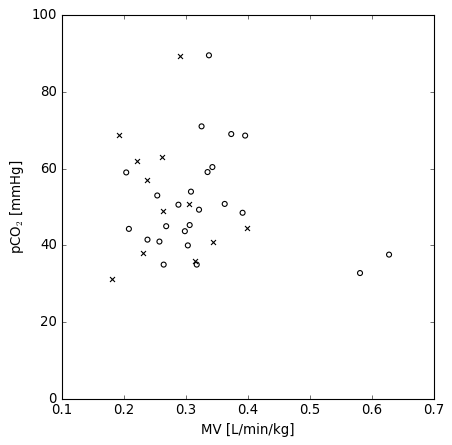

In [144]:
dpi=300; filetype = 'jpg'

fig,ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(SIPPV_MV_CO2['MV_kg'], SIPPV_MV_CO2['pCO2'], marker='o', facecolors='none', color ='black')
ax.scatter(SIMV_MV_CO2['MV_kg'], SIMV_MV_CO2['pCO2'], marker = 'x', color = 'black')
ax.set_ylim(0,100)
ax.set_xlabel('MV [L/min/kg]')
ax.set_ylabel('pCO$_2$ [mmHg]')
fig.savefig(os.path.join(DIR_WRITE, f'MV_CO2.{filetype}'), dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1);

In [145]:
VG_VT_CO2 = pd.merge(left = data_vg_all.groupby(level=0)[['VTemand_kg']].mean(),
    right = blood_gases_last_frme['pCO2'].astype('float'), how='inner', left_index=True, right_index=True).dropna(how='any')
VG_VT_CO2.head(2)

,VTemand_kg,pCO2
AL000036,4.019525,59.0
AL000089,5.771314,44.0


In [146]:
noVG_VT_CO2 = pd.merge(left = data_novg_all.groupby(level=0)[['VTemand_kg']].mean(),
    right = blood_gases_last_frme['pCO2'].astype('float'), how='inner', left_index=True, right_index=True).dropna(how='any')
noVG_VT_CO2.head(2)

,VTemand_kg,pCO2
AL000029,6.747773,40.8
AL000138,3.717836,57.0


In [147]:
VG_noVG_VTCO2 = pd.concat([VG_VT_CO2, noVG_VT_CO2], keys = ['VG', 'noVG'])

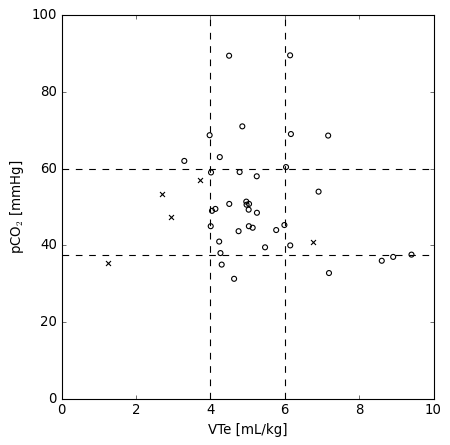

In [148]:
dpi=300; filetype = 'jpg'

fig,ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(VG_VT_CO2['VTemand_kg'], VG_VT_CO2['pCO2'], marker='o', facecolors='none', color ='black')
ax.scatter(noVG_VT_CO2['VTemand_kg'], noVG_VT_CO2['pCO2'], marker = 'x', color = 'black')
ax.hlines(37.5, 0, 10, color='black', linestyle='dashed')
ax.hlines(60, 0, 10, color='black', linestyle='dashed')
ax.vlines(4, 0, 100, color='black', linestyle='dashed')
ax.vlines(6, 0, 100, color='black', linestyle='dashed')
ax.set_xlim(0, 10)
ax.set_ylim(0,100)
ax.set_xlabel('VTe [mL/kg]')
ax.set_ylabel('pCO$_2$ [mmHg]')
fig.savefig(os.path.join(DIR_WRITE, f'VT_CO2.{filetype}'), dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1);